FileNotFoundError: [Errno 2] No such file or directory: "path+'/'+multi.pdf"

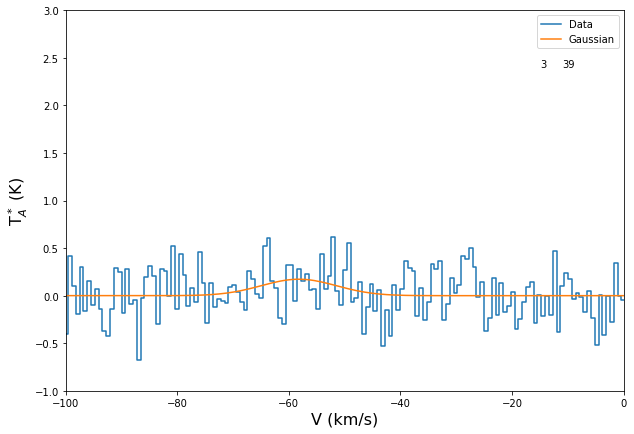

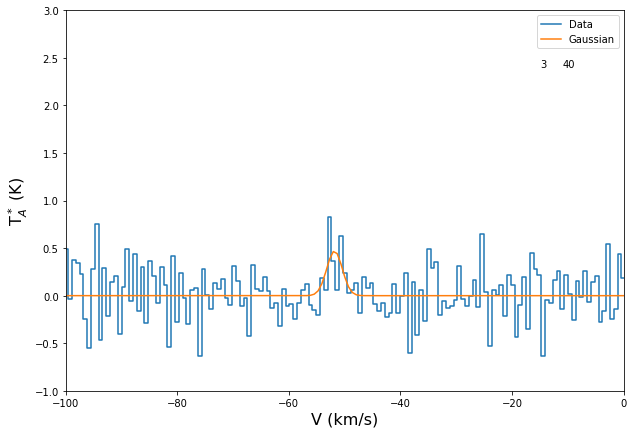

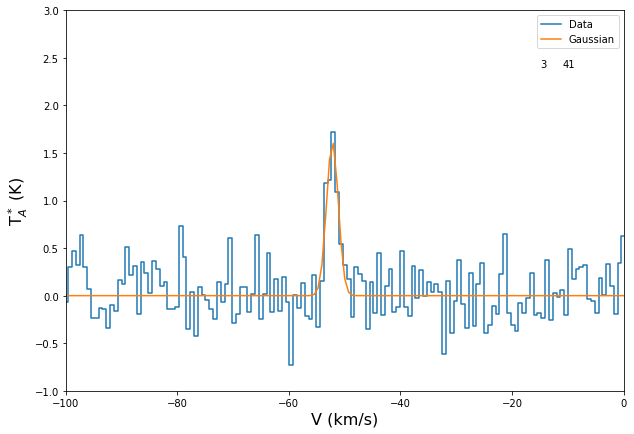

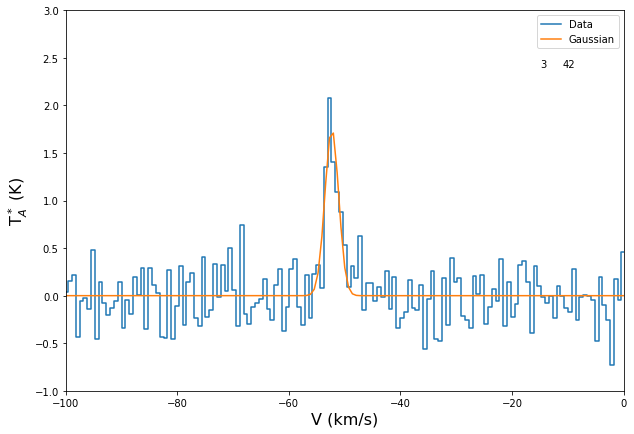

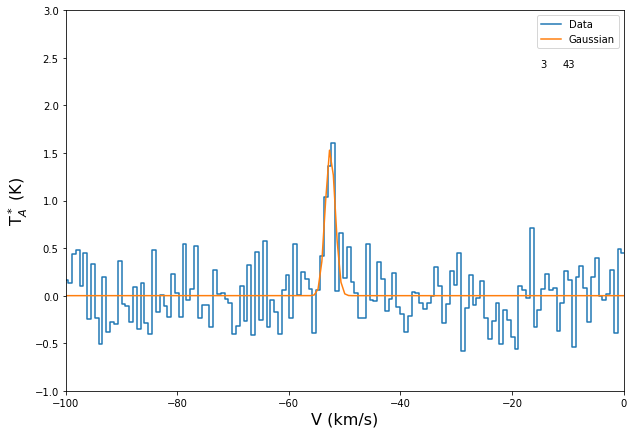

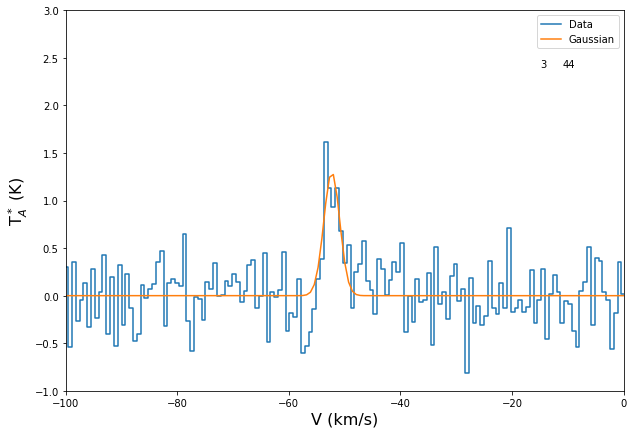

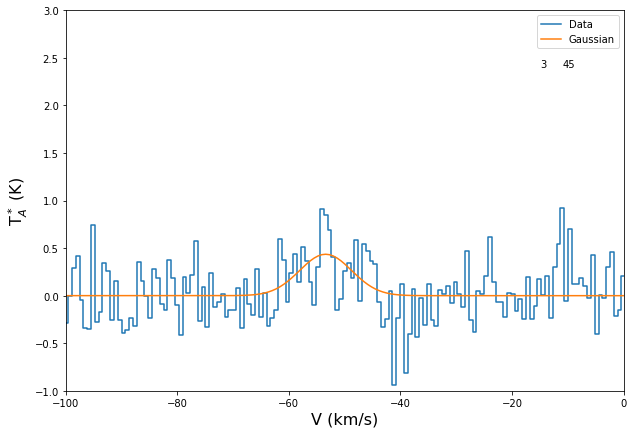

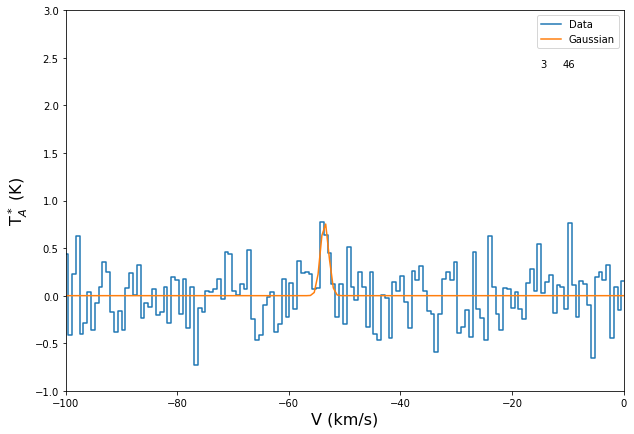

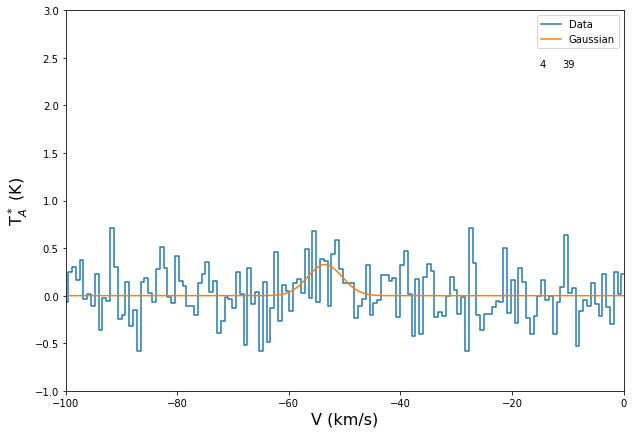

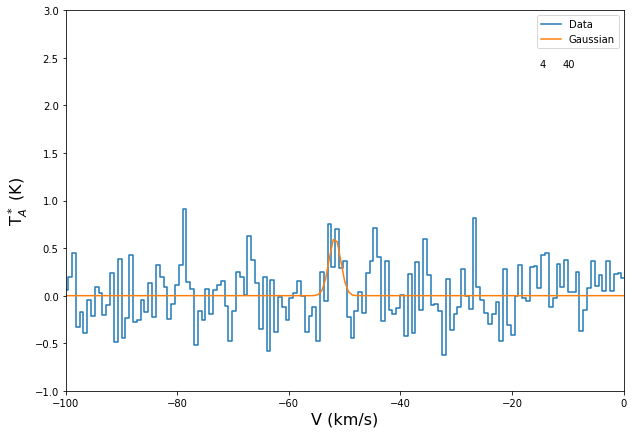

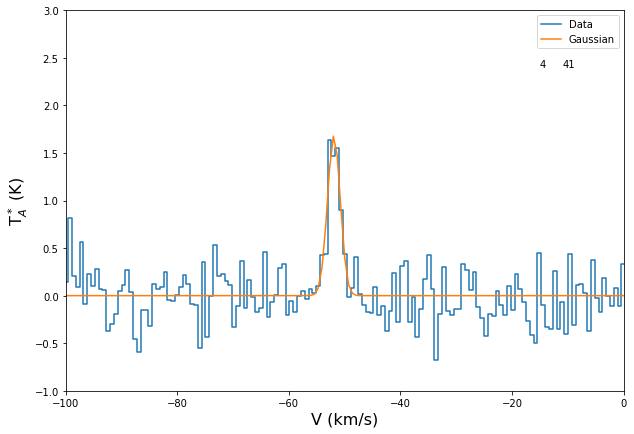

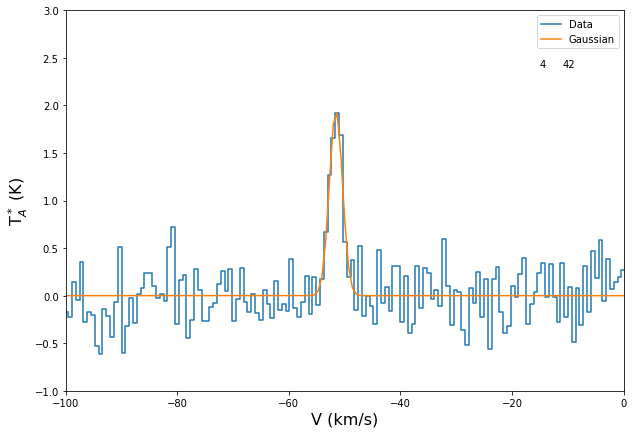

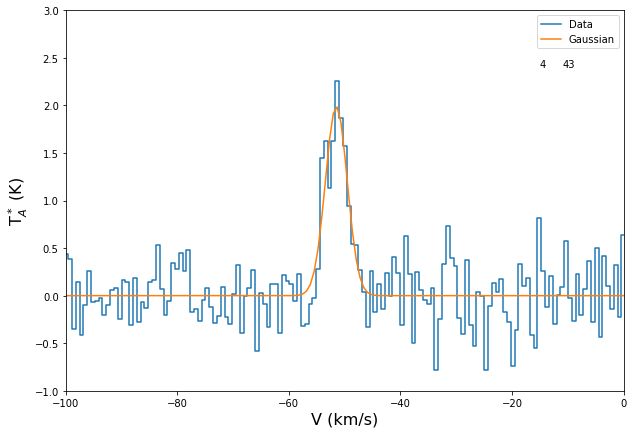

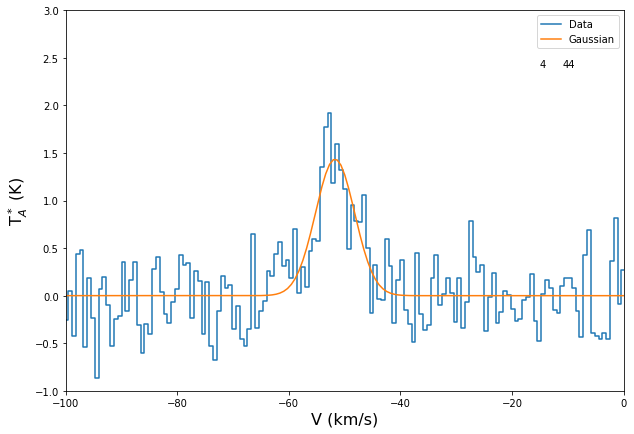

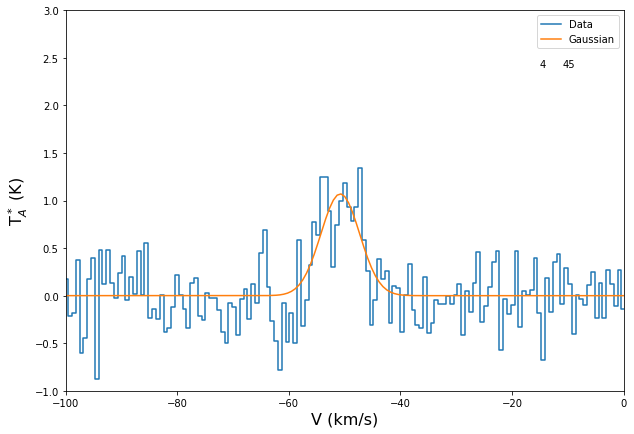

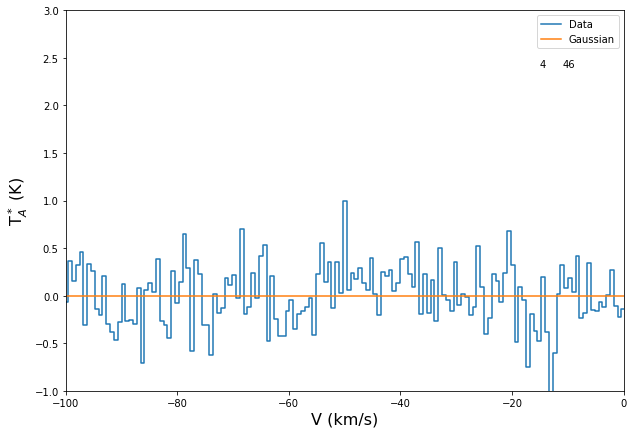

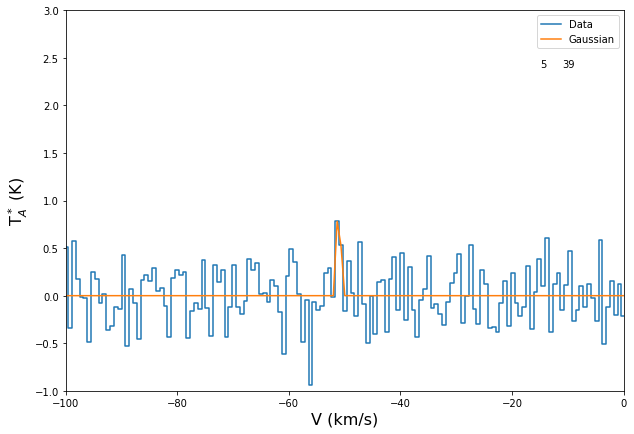

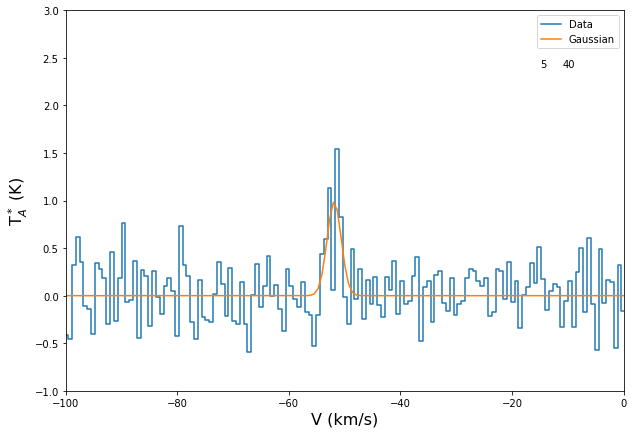

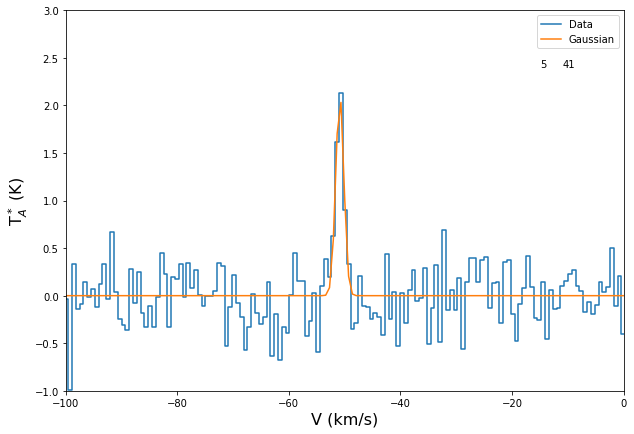

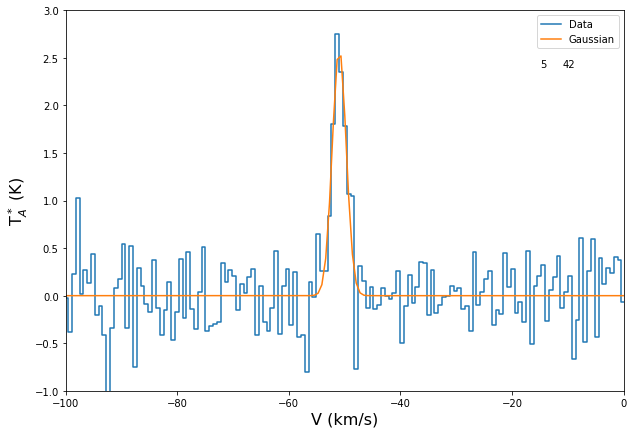

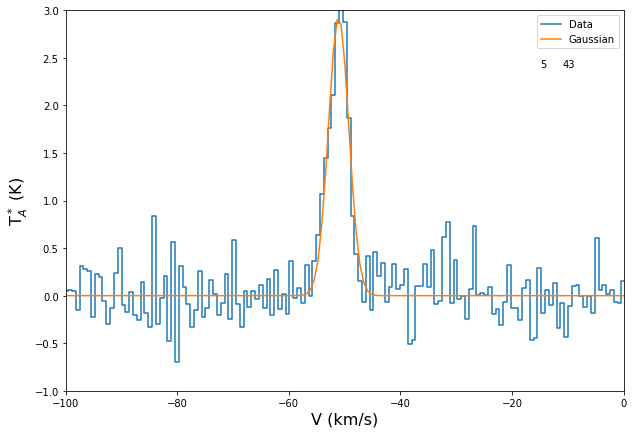

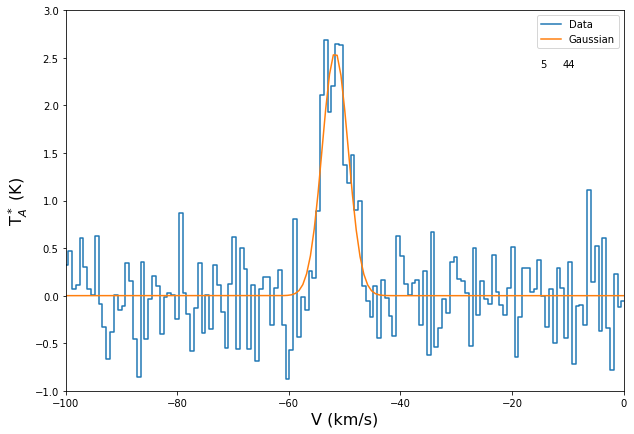

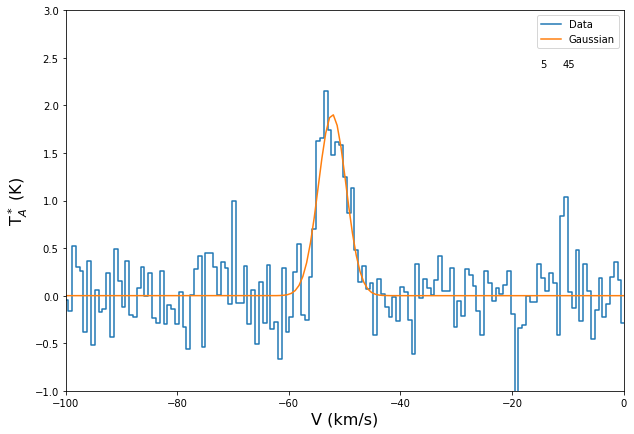

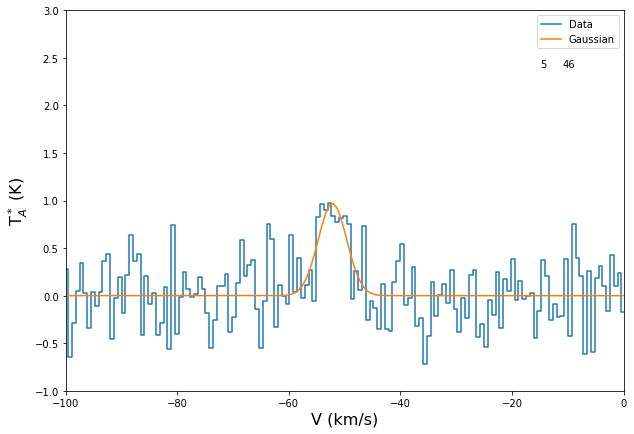

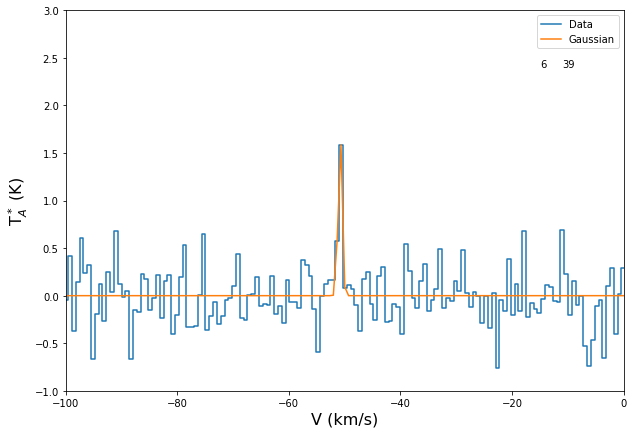

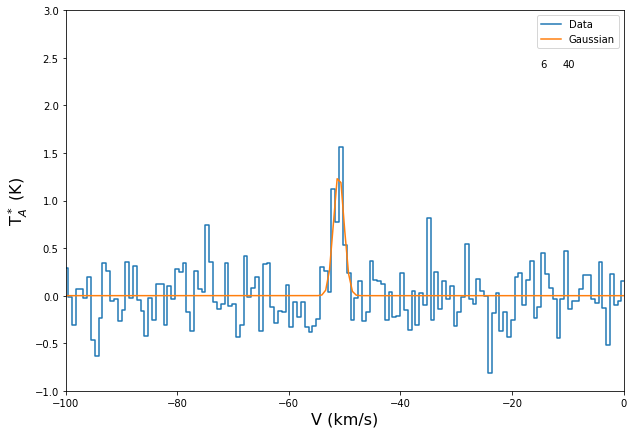

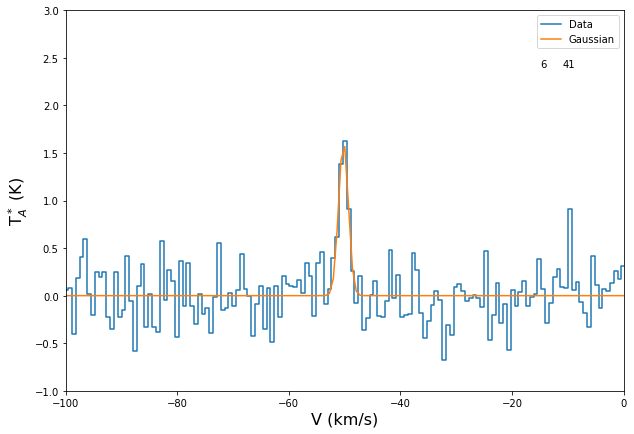

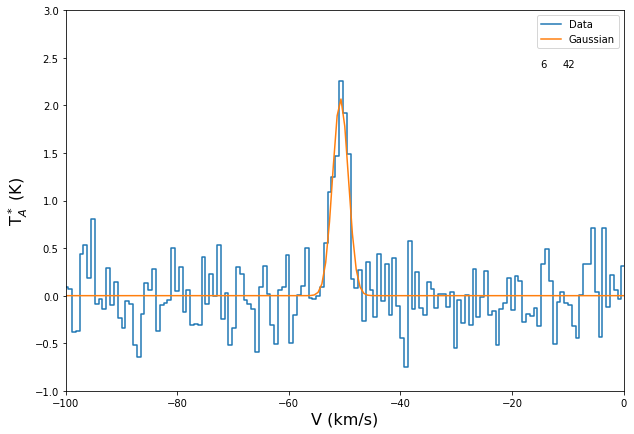

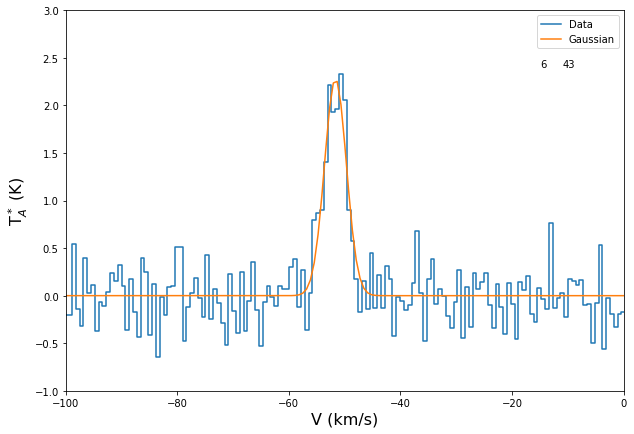

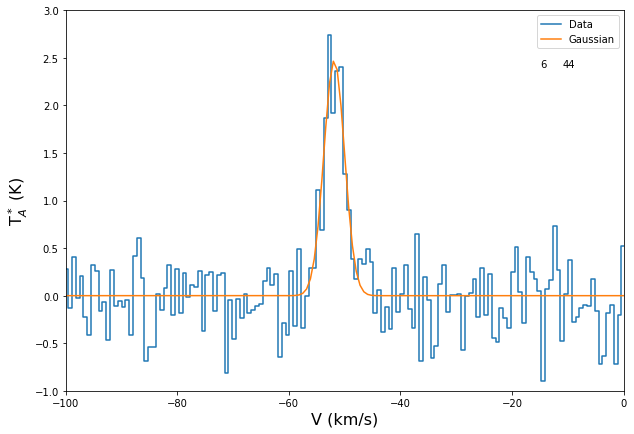

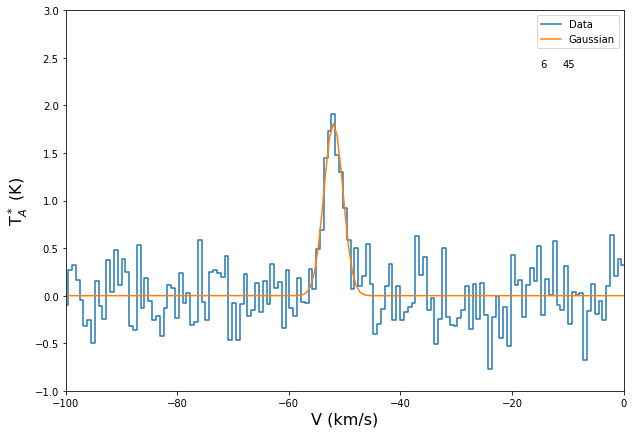

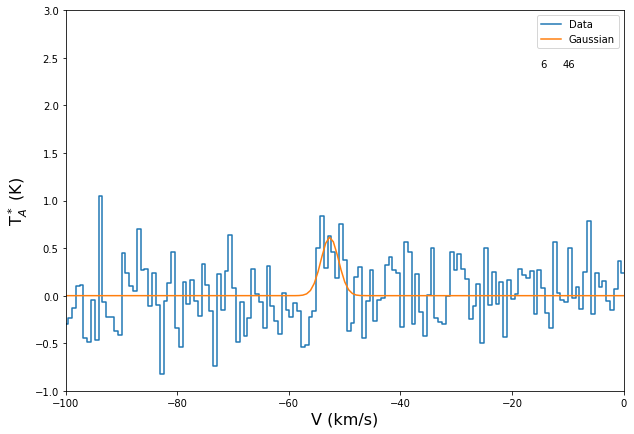

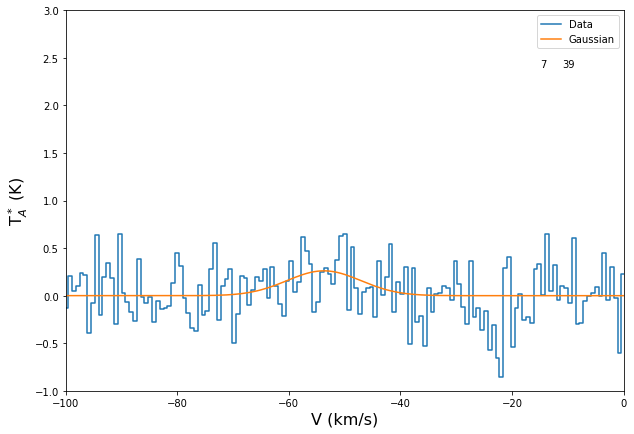

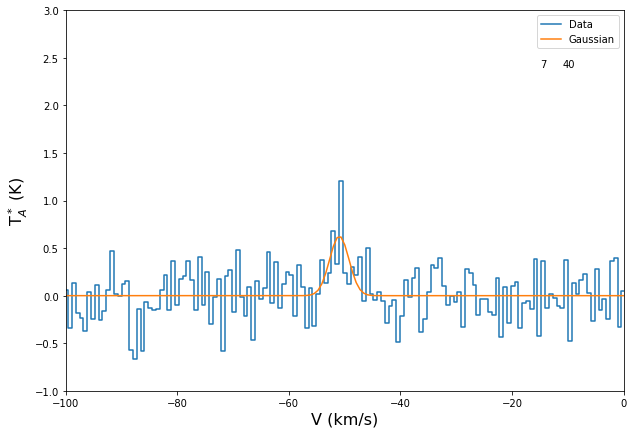

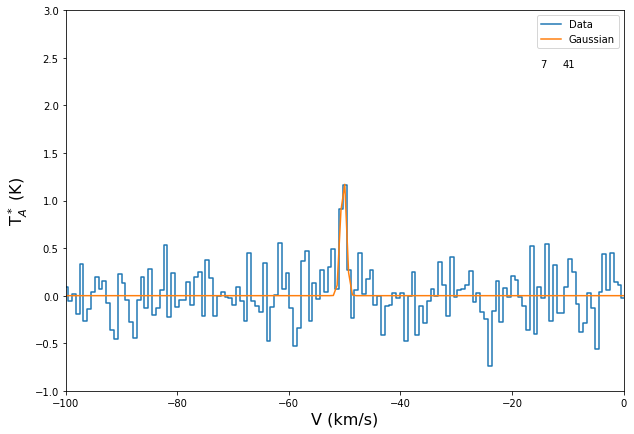

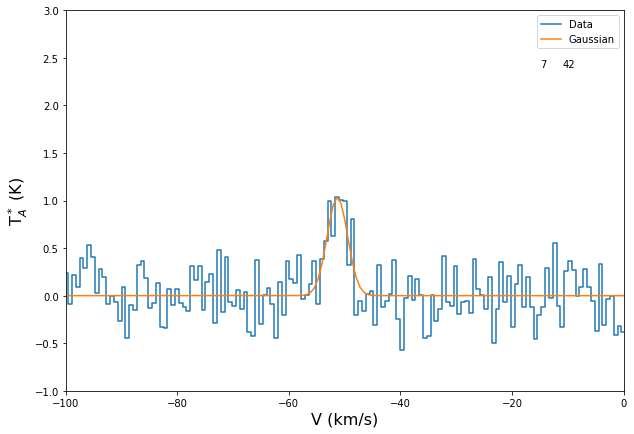

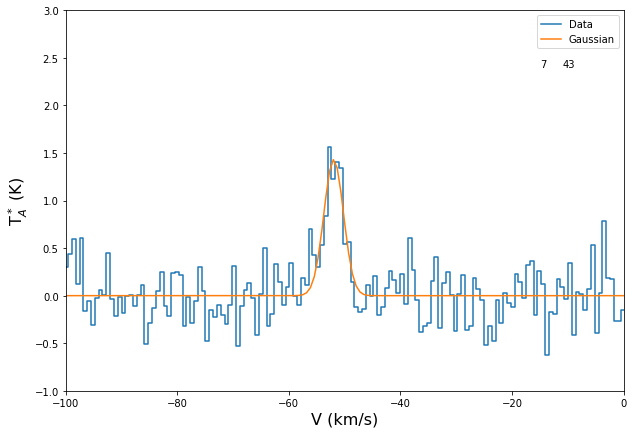

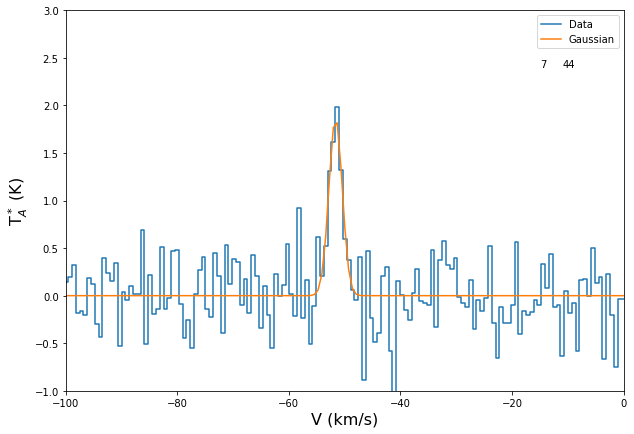

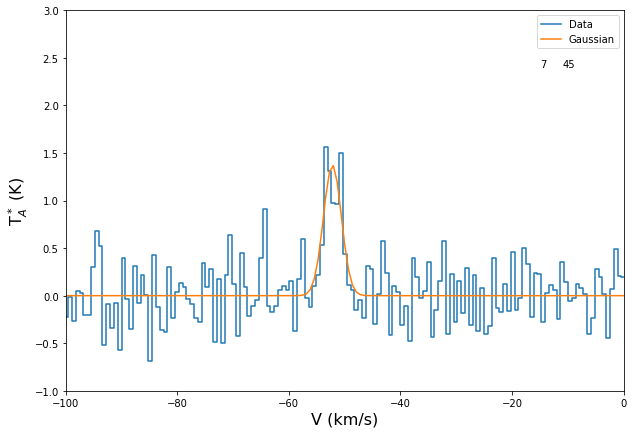

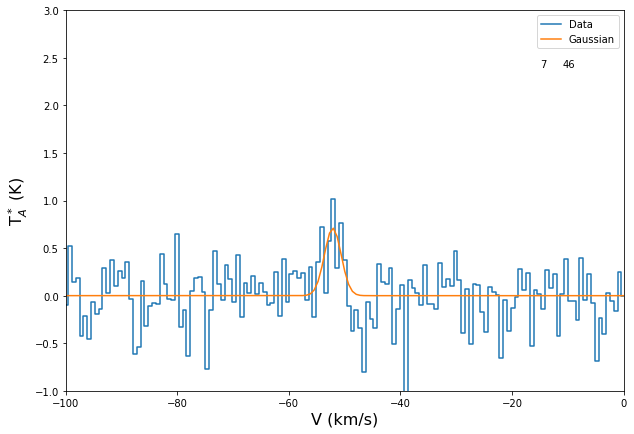

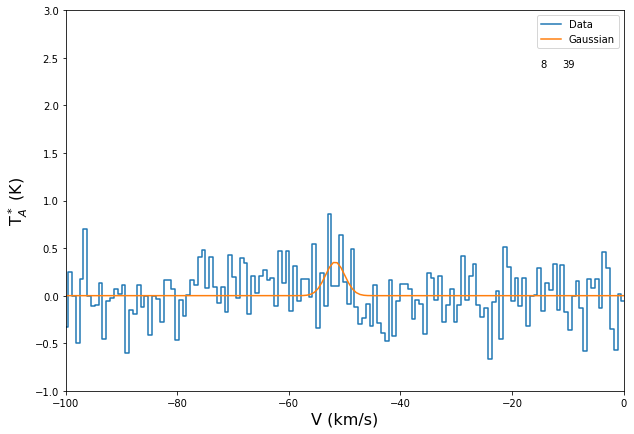

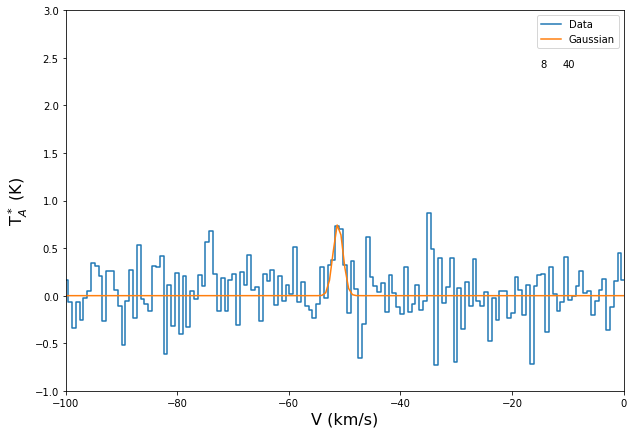

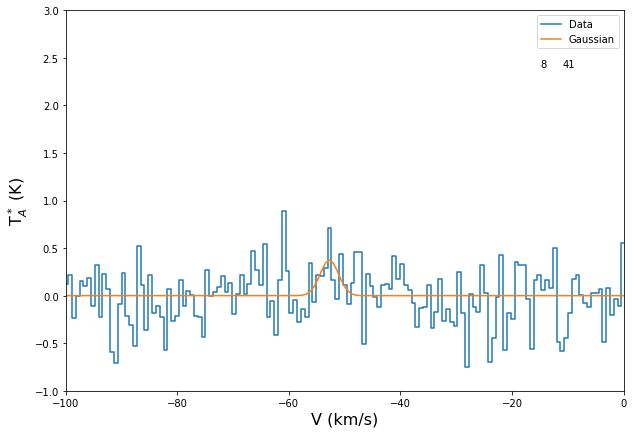

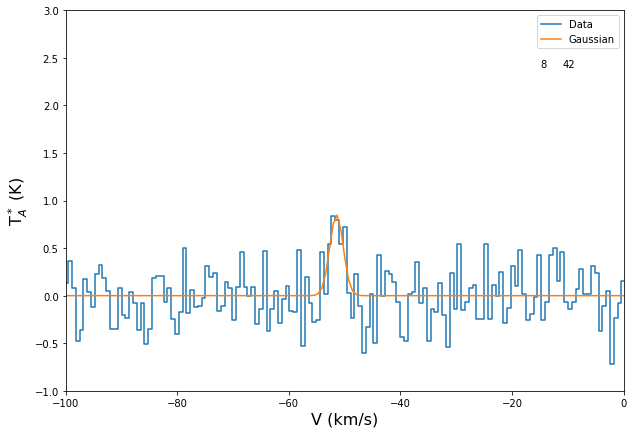

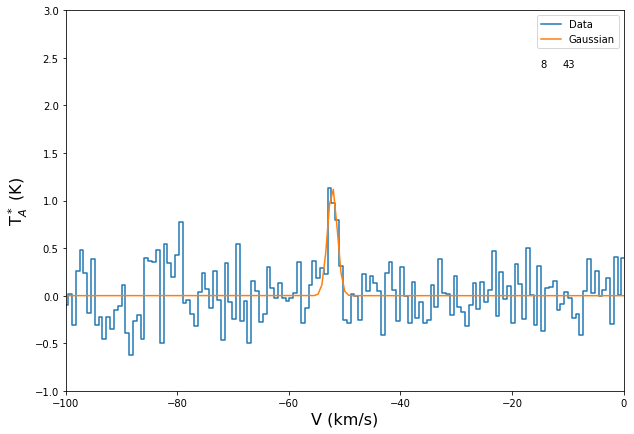

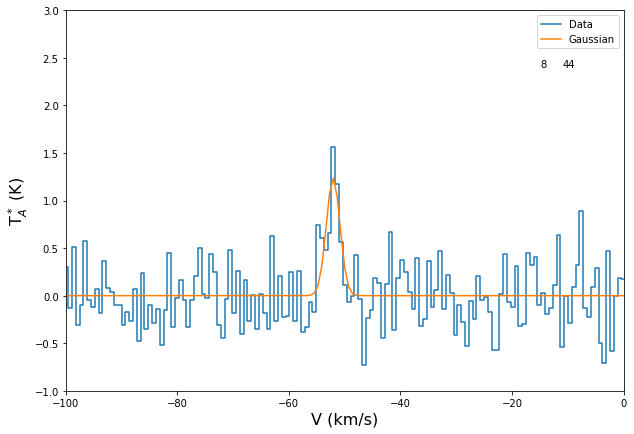

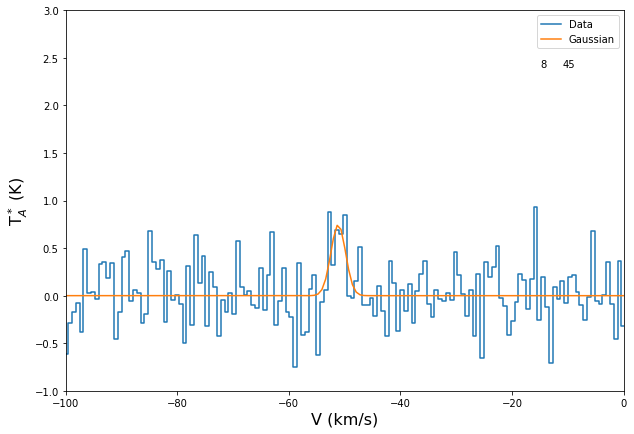

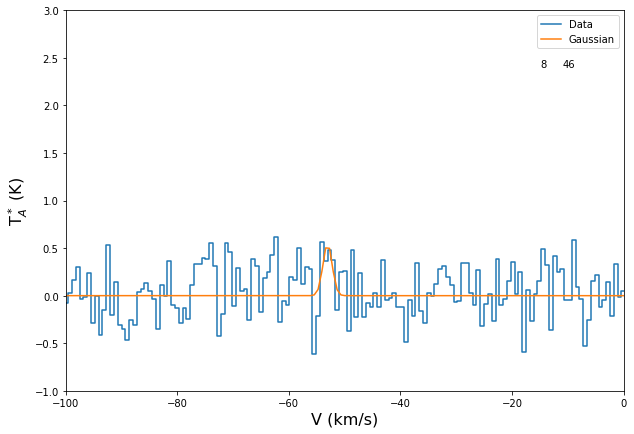

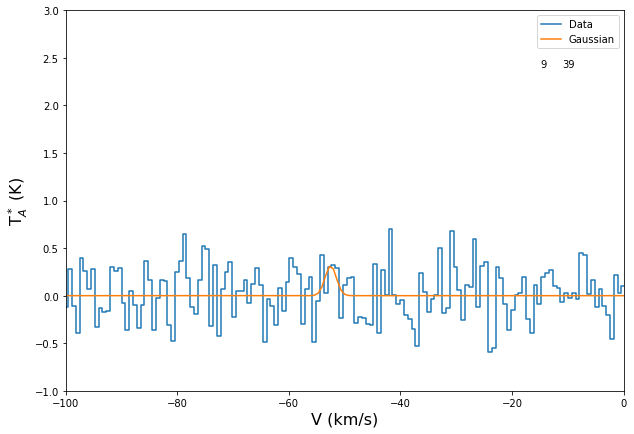

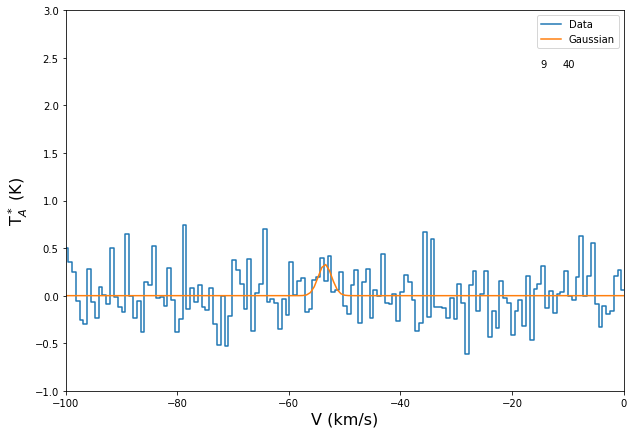

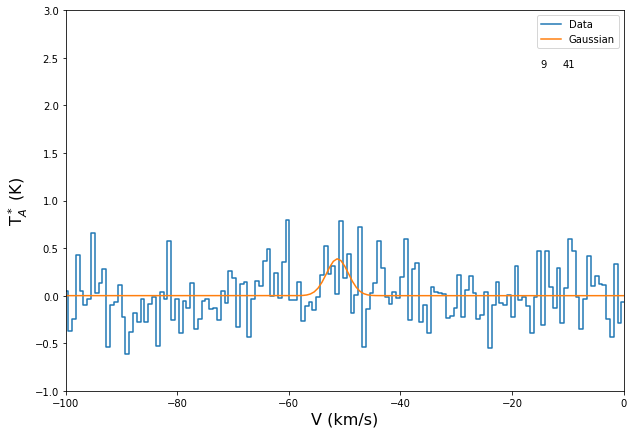

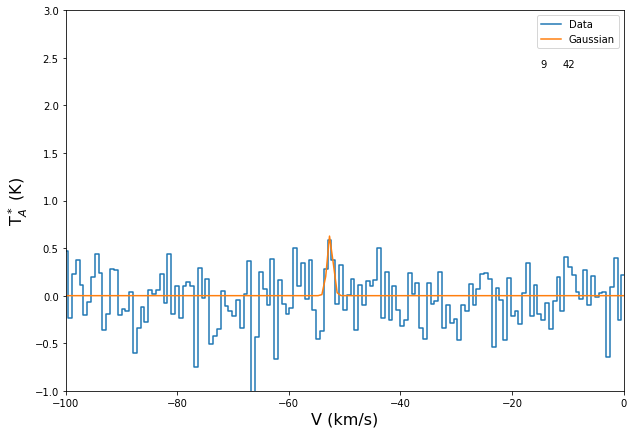

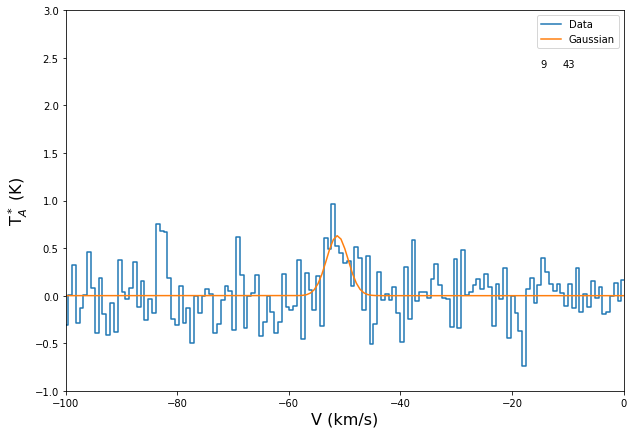

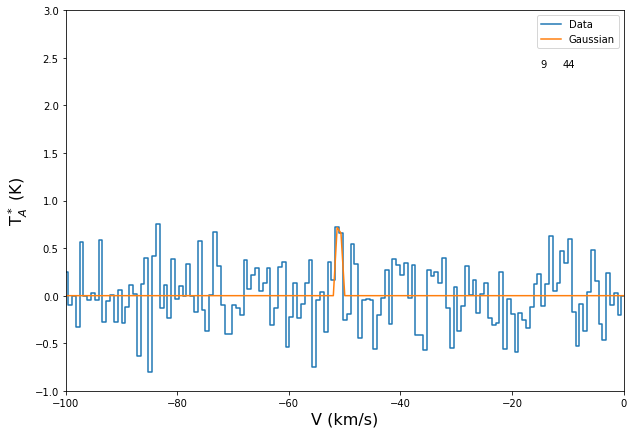

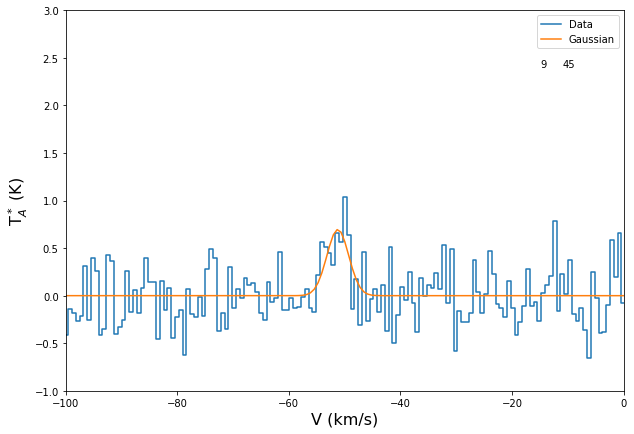

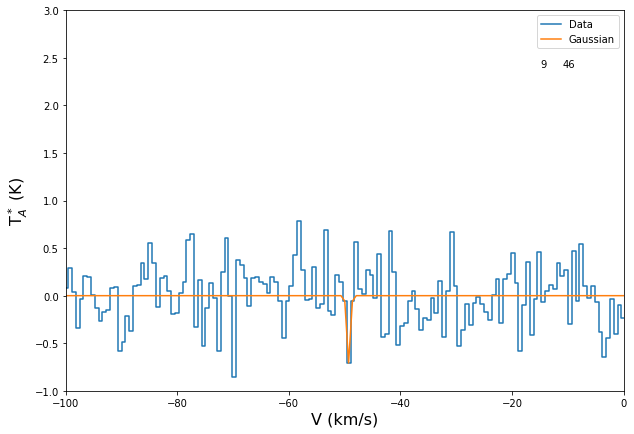

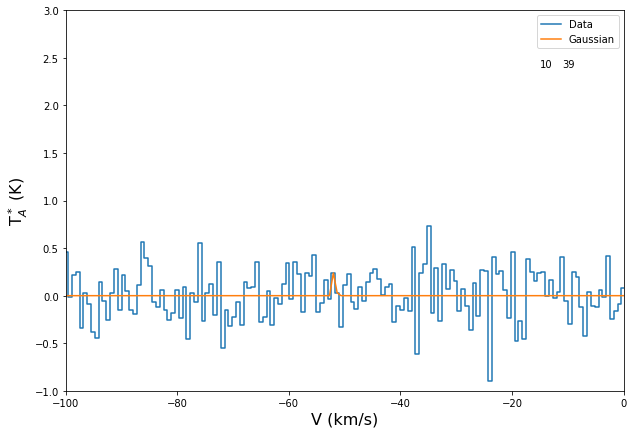

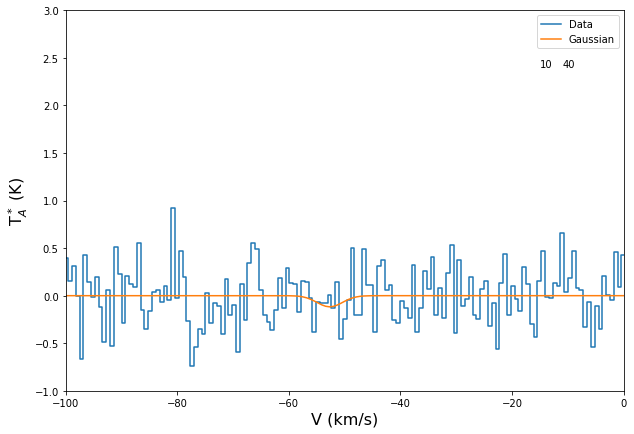

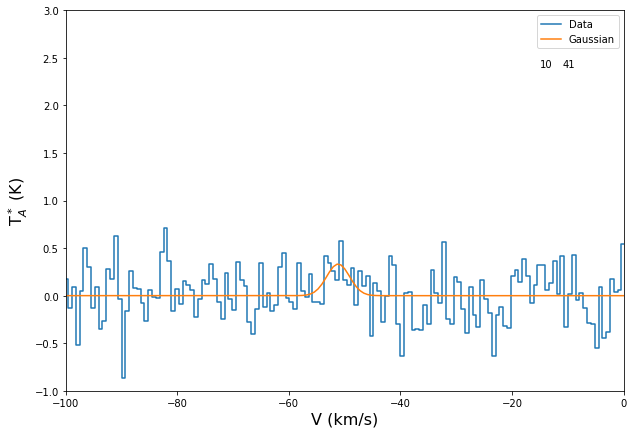

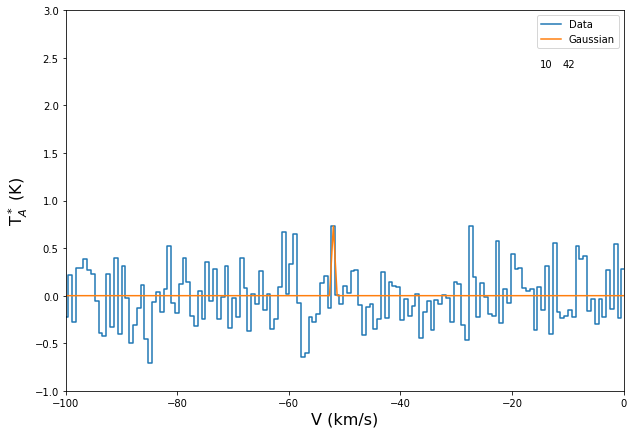

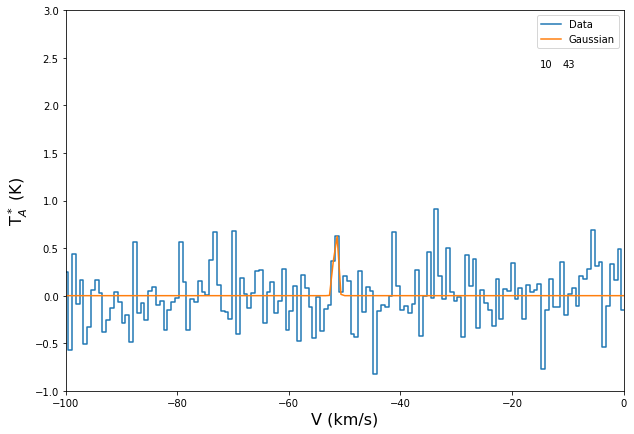

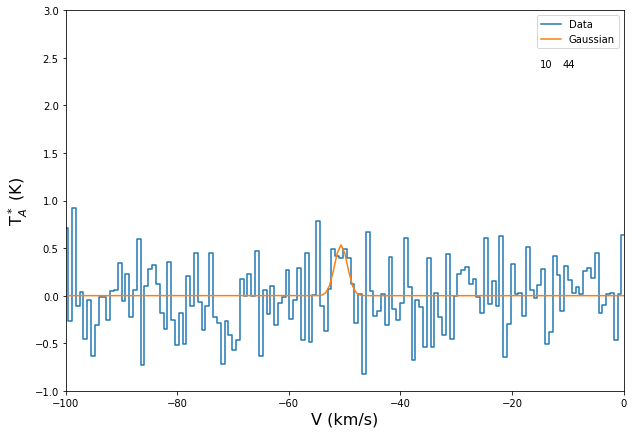

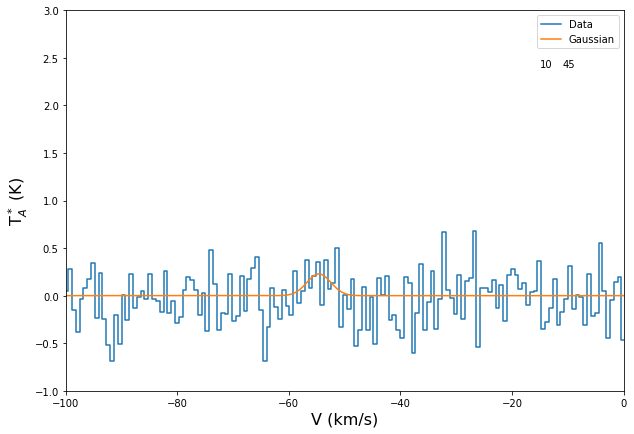

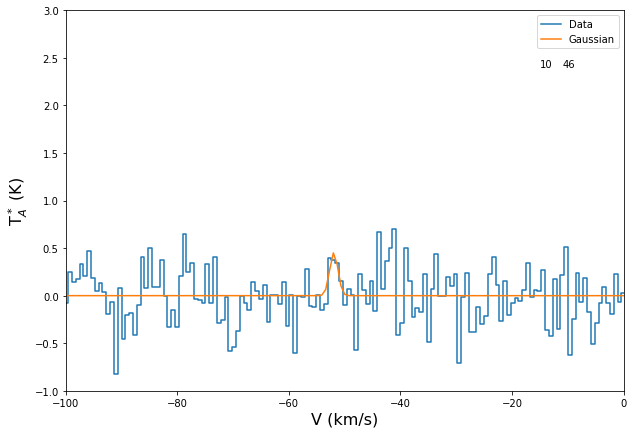

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import ascii
from astropy.table import Table

import warnings
warnings.filterwarnings('ignore') # Turn warnings off (because they're annoyong!)

# Change the parameters below for each new source
################################################

path='/Users/jane/Desktop'   # path to file
filename='s138_HCO+_smo.fits'       # input fits file name
outfile = 's138_HCO+_gaussfits.txt' # file name of the gaussian fit results

vel_guess = -52  # The initial guess for the centroid velocity of the gaussian fit
dv_min = 1       # set a minimum acceptable line width
dv_max = 9       # set a maximum acceptable line width
snr_min = 2.5    # set a minumum acceptable SNR

# set the range of pixels in the x direction over which to loop
min_xpix = 3
max_xpix = 10

# set the range of pixels in the y direction over which to loop
min_ypix = 39
max_ypix = 46

# set the velocity range over which to calculate the line integrated intensity
min_vline = -56
max_vline = -48

#set the spectral resolution of the spectra in km/s
deltaV = 0.4

#################################################

#JCMT efficiency at 230 GHz to convert TA* to Tmb
eta = 0.6

# retrieving the source data and information
datfile = fits.open(path+'/'+filename)
cube = SpectralCube.read(datfile)
wcs = WCS(datfile[0].header) # vel and position info from WCS in header

# extract the world coordinates of all the pixels using the world property, 
# which returns the spectral axis then the two positional coordinates in reverse order 
# (in the same order as the data indices). 
velo, lat, long  = cube.world[:] 

# convert the velocity units from m/s (in the fits header) to km/s
cube2 = cube.with_spectral_unit(u.km / u.s)

# print column headers to screen
#print("x  y          Glat.                 Glong.           TA   Tmb    V     Sig   Fwhm")
#print("                                                      K    K    km/s   km/s  km/s")
        
# initialize the arrays to write to an ascii table file at the end
x = []
y = []
glat = []
glong = []
vlsr = []
TA = []
sigma = []
fwhm = []
TAdv = []
Tmb = []
Tmbdv = []
figs = [] # to store gaussian plots in 

# sets an index for the array entries
n = 0

# Loop over all pixels in the x and y ranges provided, extract the spectrum at that pixel,
# fit a gaussian to the spectrum and print and plot the results
for i in range(min_xpix,max_xpix+1):
    for j in range(min_ypix,max_ypix+1):
        # grab a spectrum at pixel x, y 
        x.append(i)
        y.append(j)
        T = cube2[:, j, i]               # get the intensity/temperature along the spectral axis
        vel = cube2.spectral_axis        # set the velocity axis
        glat.append(lat[0,j,0])          # get the DEC/lat of pixel x/y from the world coordinates
        glong.append(long[0,0,i])        # get the RA/long of pixel x/y from the world coordinates

        # Fit the data using a Gaussian
        g_init = models.Gaussian1D(amplitude=1.0, mean=vel_guess, stddev=1.0)
        fit_g = fitting.LevMarLSQFitter()
        g = fit_g(g_init, vel, T)
        #print(g)
        
        gT = g.amplitude.value   # Line peak temperature of the gaussian fit  (K)
        gV = g.mean.value        # line centre velocity of the gaussian fit (km/s)
        gS = g.stddev.value      # standard deviation (sigma) width of the gaussian fit (km/s)
        
        noise = T.std()                      # Calculate the rms noise in the spectrum
        intnoise = deltaV * noise * u.km / u.s  # multiple the noise by the channel width we can calculate the SNR using the intergrated intensity/moment 0
        newgT = gT * u.K                     # give the Gaussian fit temp the units of K                   
        #print('noise = ',noise)
        #print('integrated noise = ', intnoise)
        #print('max = ',max)
              
        # calculate the integrated intensity of the spectrum over the line
        line = cube2.spectral_slab(min_vline*u.km / u.s, max_vline*u.km / u.s)
        max = line[:,j,i].max()       # calculate the maximum channel height in the region covered by the line
        mom0 = line.moment(order=0)
        mom_line = abs(mom0[j,i])     # extract the moment 0 value fo the desire x, y position/pixel
        #print('moment line =',mom_line)
  
        # calculate the SNR 
        snr = mom_line/intnoise
        #print('SNR = ',snr)
        
        # If the SNR is > some value, the max channel is >  something * noise
        # and the FWHM is > some minimum width and < some maximum width
        # then accept the values of the gaussian fits
        # if not, then we assume that the spectrum is weak, the fit is nonsense and so
        # we set the values to 0 so we know what to ignore in the table
        if snr > snr_min and max > (snr_min*noise) and (2.355*gS) > dv_min and (2.355*gS) < dv_max :
            TA.append(gT)               # Line peak temperature of the gaussian fit  (K)
            vlsr.append(gV)             # line centre velocity of the gaussian fit (km/s)
            sigma.append(gS)            # standard deviation (sigma) width of the gaussian fit (km/s)
            fwhm.append(2.355 * gS)     # Full Width at Half Maximum of the gaussian fit  (km/s)
            Tmb.append(gT/eta)          # Calibrated Line peak temperature of the gaussian fit  (K)
        else:
            TA.append(0)           # Line peak temperature of the gaussian fit  (K)
            vlsr.append(0)         # line centre velocity of the gaussian fit (km/s)
            sigma.append(0)        # standard deviation (sigma) width of the gaussian fit (km/s)
            fwhm.append(0)         # Full Width at Half Maximum of the gaussian fit  (km/s)
            Tmb.append(0)          # Calibrated Line peak temperature of the gaussian fit  (K)
        
        # print the fit results to the screen
        #print(x[n], y[n], glat[n], glong[n], "%5.2f"%TA[n], "%5.2f"%Tmb[n], "%5.2f"%vlsr[n],"%5.2f"%sigma[n], "%5.2f"%fwhm[n])
         
        # plot each of the spectra and fits    
        fig = plt.figure(figsize=(10,7), facecolor='white')
        ax = fig.add_subplot(111)  # make a single panel subplot
       # im = ax.plot(vel,T, label='Data')  # plot the data
        im = ax.step(vel, T, where='mid', label='Data')
        im = ax.plot(vel, g(vel), label='Gaussian') # plot the gaussian fit
        ax.set_xlim([-100,0])
        ax.set_ylim([-1,3])
        ax.set_xlabel("V (km/s)", fontsize=16)
        ax.set_ylabel("T$_A^*$ (K)", fontsize=16)
        ax.text(-15,2.4,i)
        ax.text(-11,2.4,j)
        ax.legend()
        figs.append(fig)
        
        n += 1    #increment the array index

# Set the header line, the parameters, and the format of the parameters to 
# write to an ascii table file        
out = Table()
out['Pix_x'] = x
out['Pix_y'] = y
out['GLat(deg)'] = glat
out['GLat(deg)'].info.format = '8.5f'
out['GLong(deg)'] = glong
out['GLong(deg)'].info.format = '8.5f'
out['TA(K)'] = TA
out['TA(K)'].info.format = '6.2f'
out['Tmb(K)'] = Tmb
out['Tmb(K)'].info.format = '6.2f'
out['VLSR(km/s)'] = vlsr
out['VLSR(km/s)'].info.format = '6.2f'
out['sigma(km/s)'] = sigma
out['sigma(km/s)'].info.format = '6.2f'
out['FWHM(km/s)'] = fwhm
out['FWHM(km/s)'].info.format = '6.2f'


# Write the gaussian fits of all pixels to a text file 
ascii.write(out, path+'/'+outfile,  overwrite=True, format='tab')

# Turn warnings back on
warnings.filterwarnings('default')

from matplotlib.backends.backend_pdf import PdfPages

def save_multi_image(filename):
   pp = PdfPages(filename)
   for fig in figs:
      fig.savefig(pp, format='pdf')
   pp.close()

filename = path+'/'+multi.pdf
save_multi_image(filename)

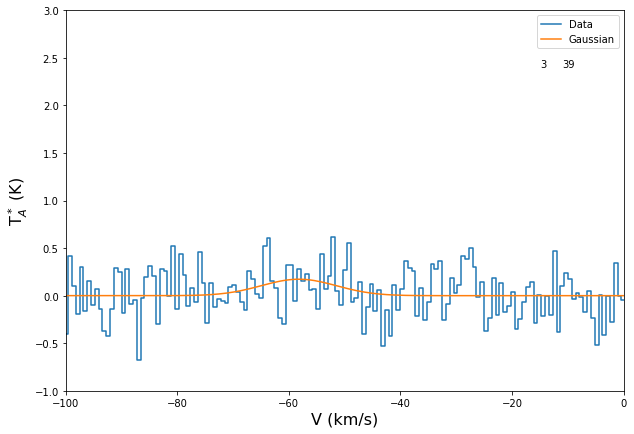

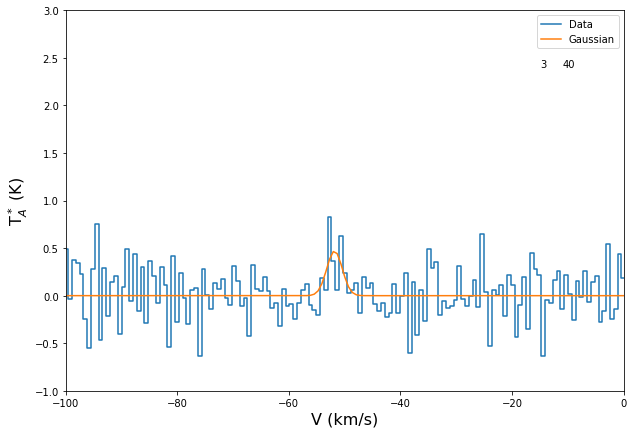

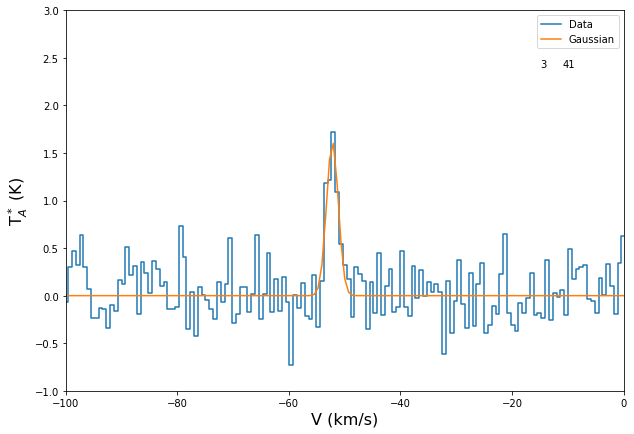

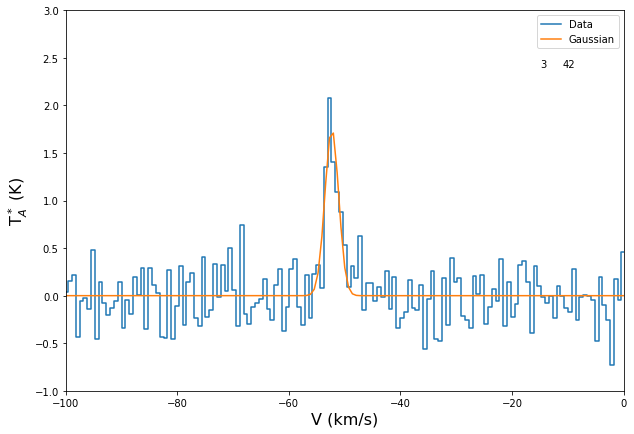

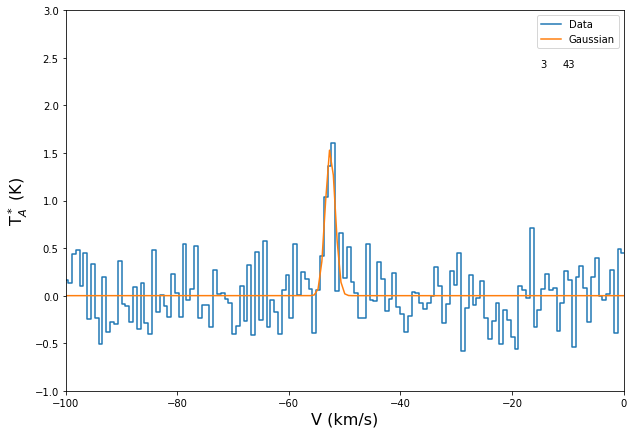

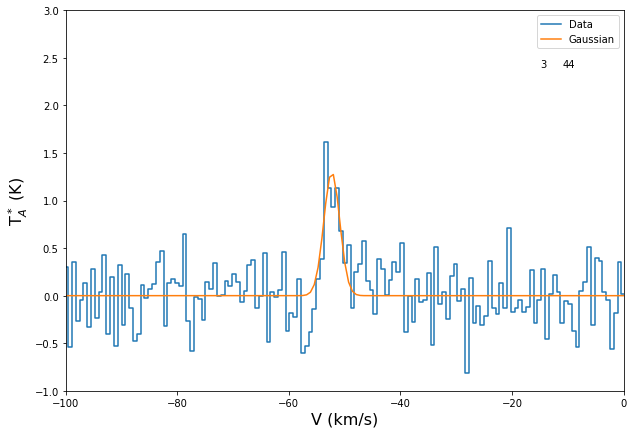

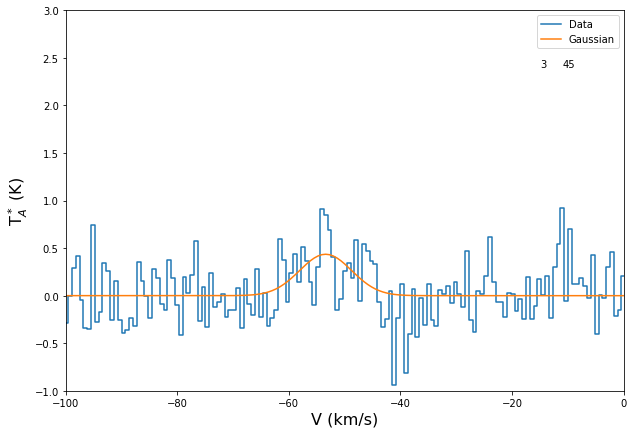

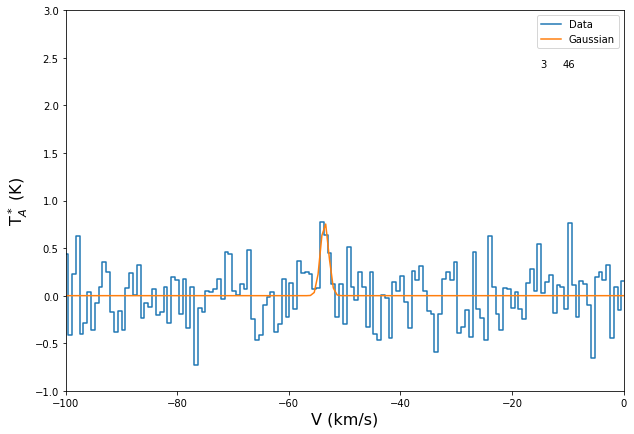

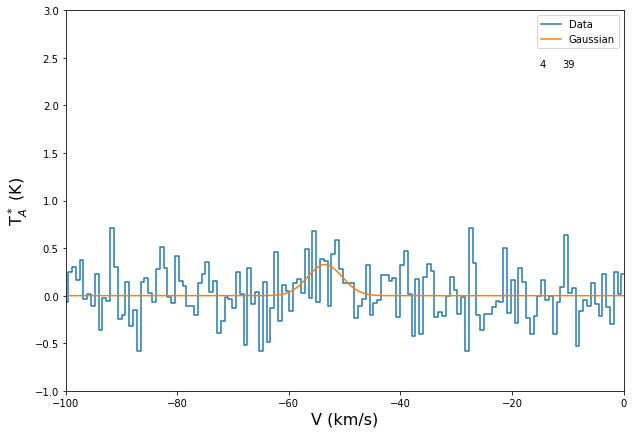

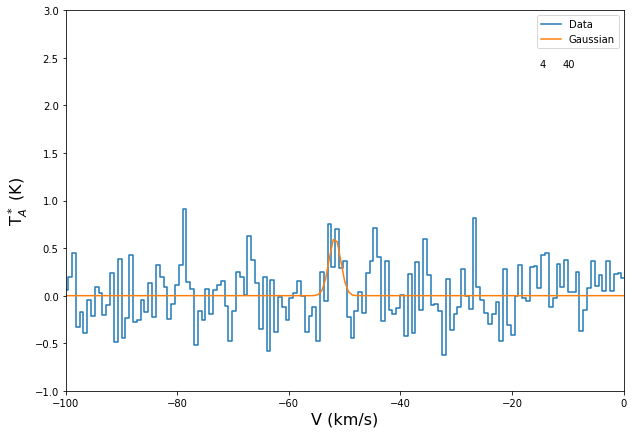

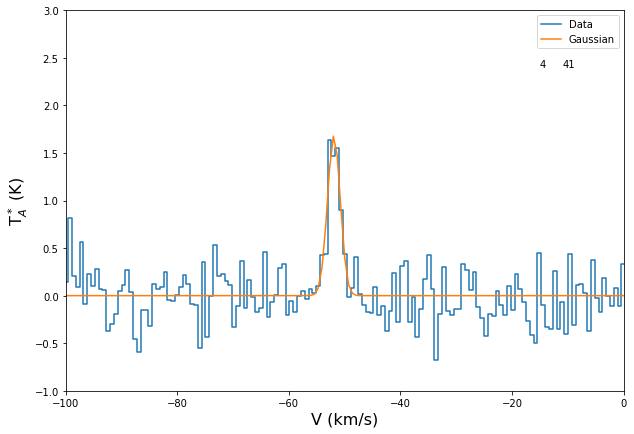

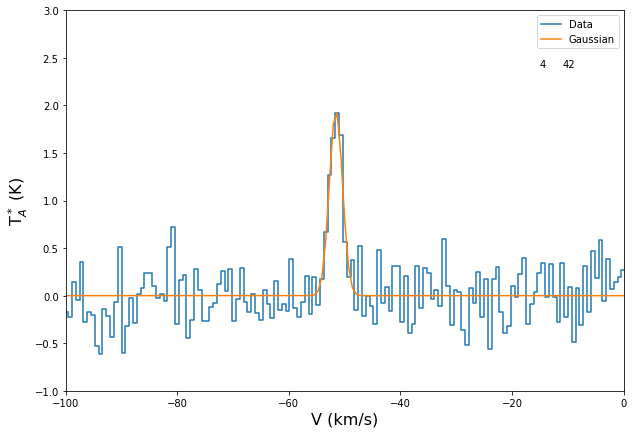

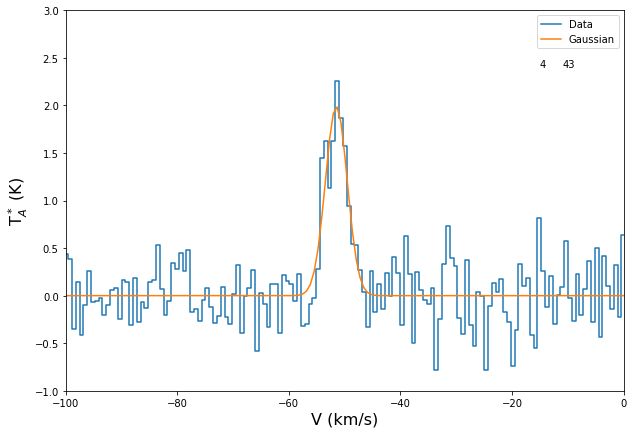

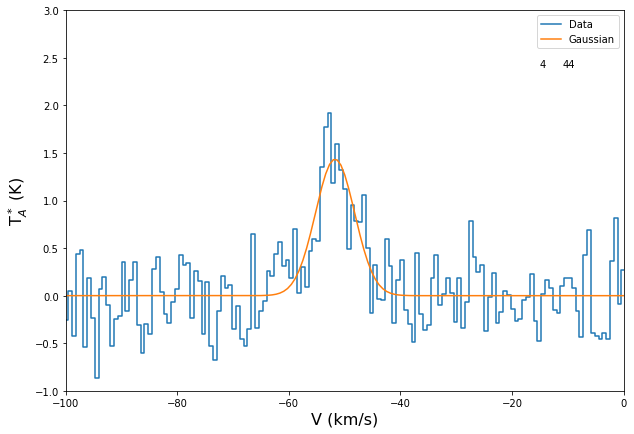

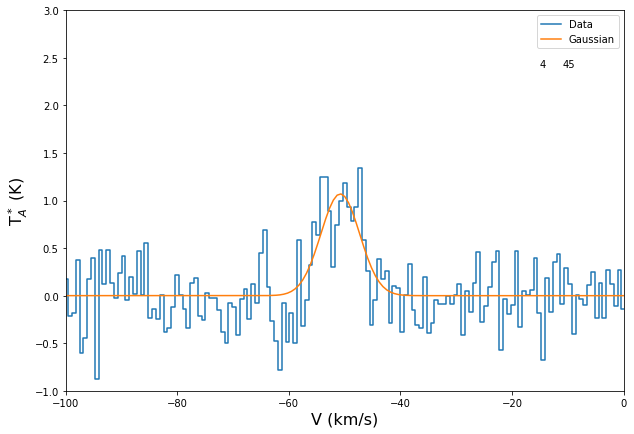

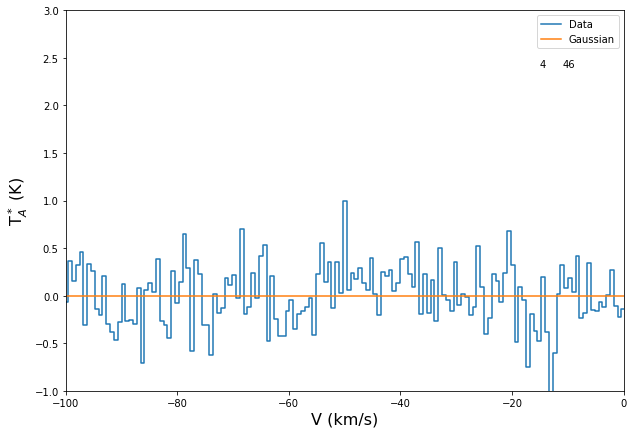

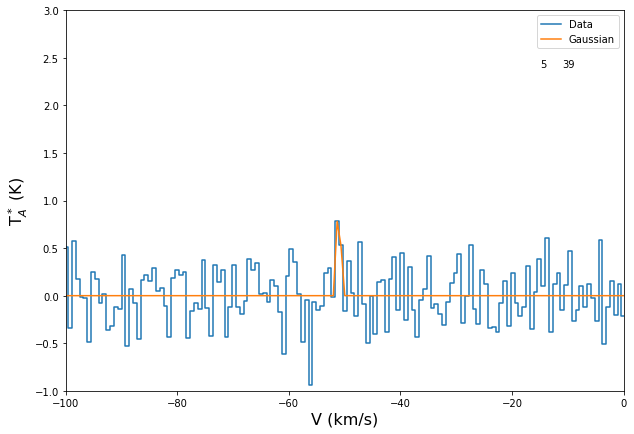

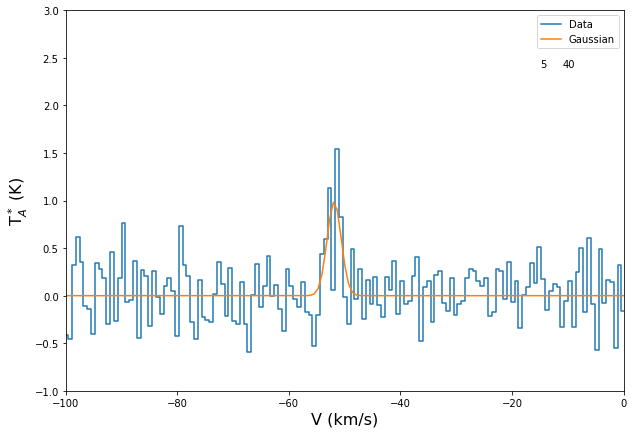

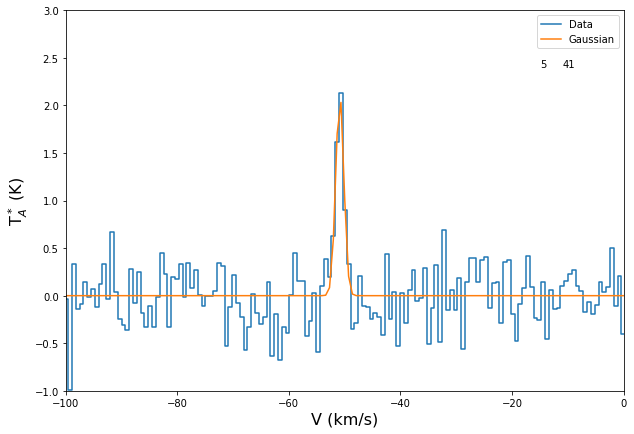

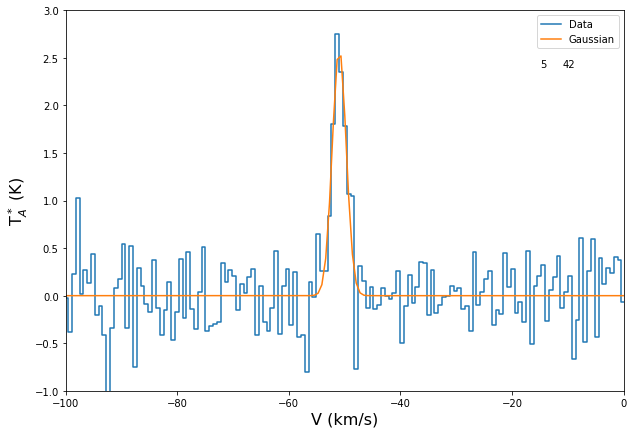

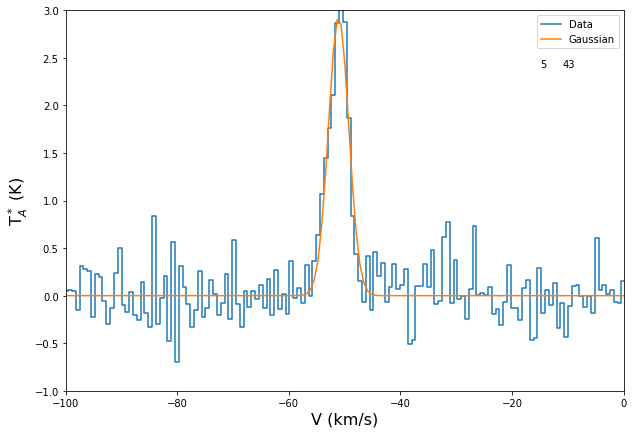

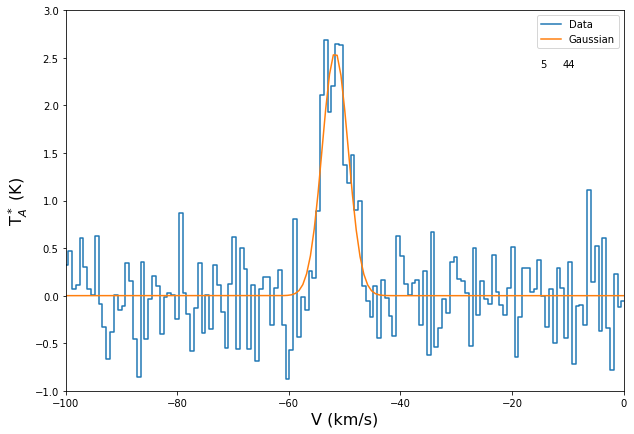

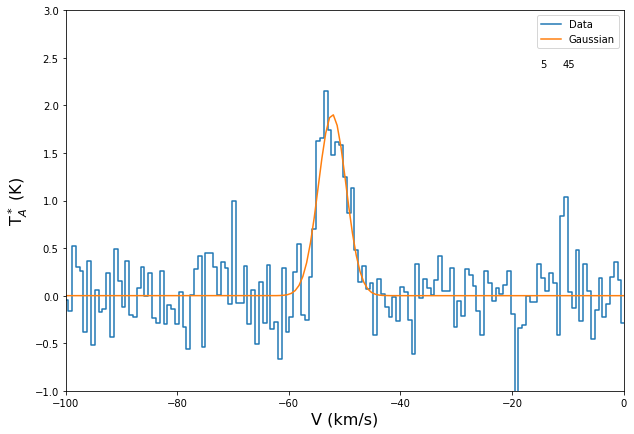

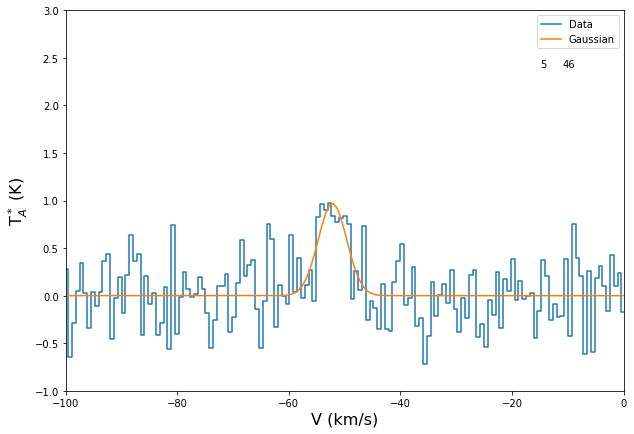

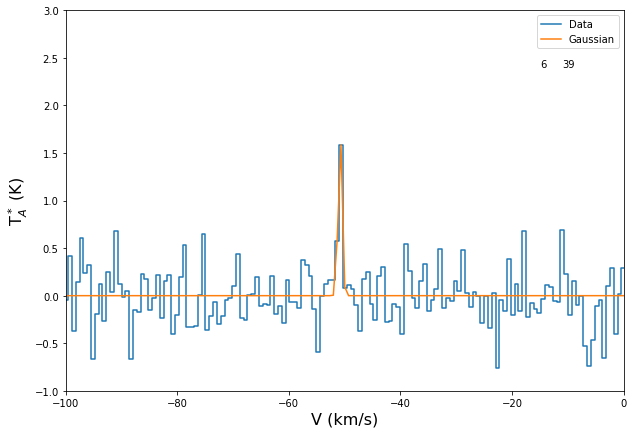

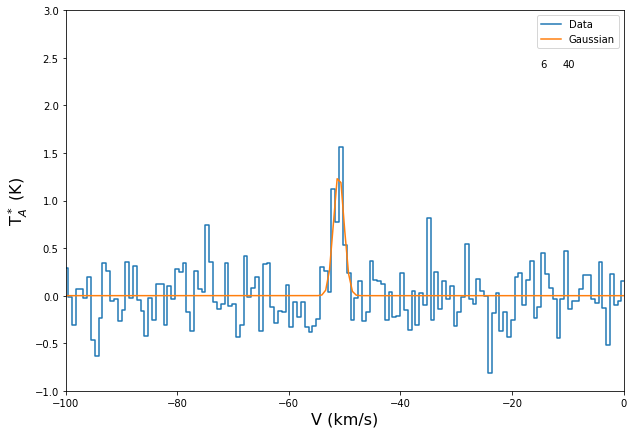

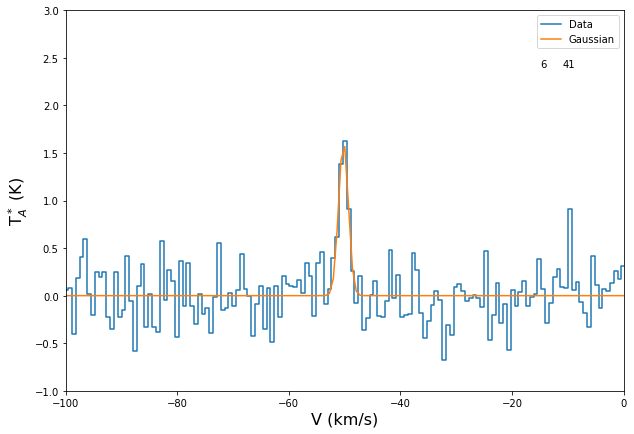

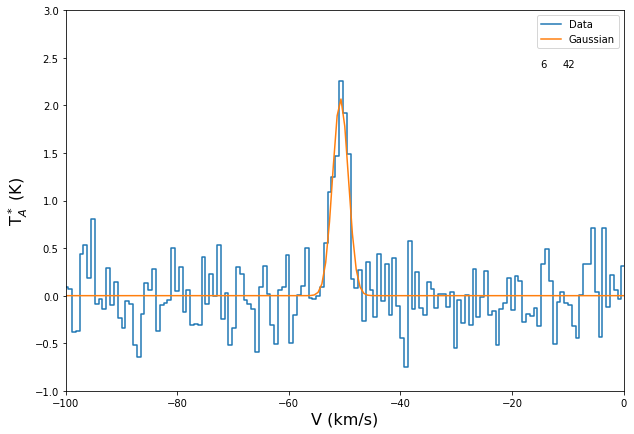

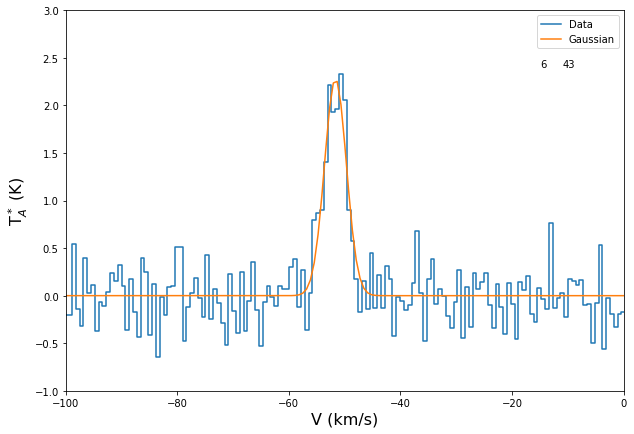

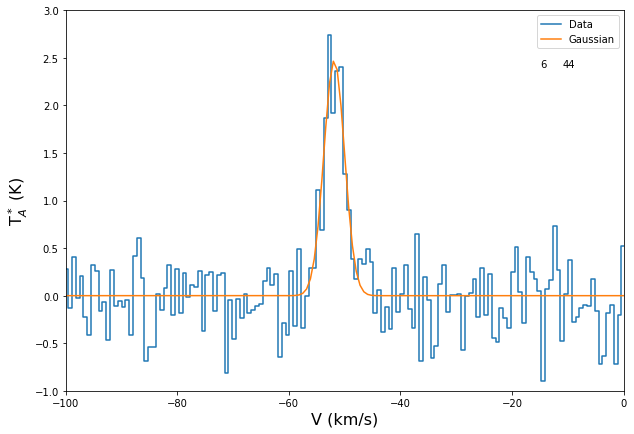

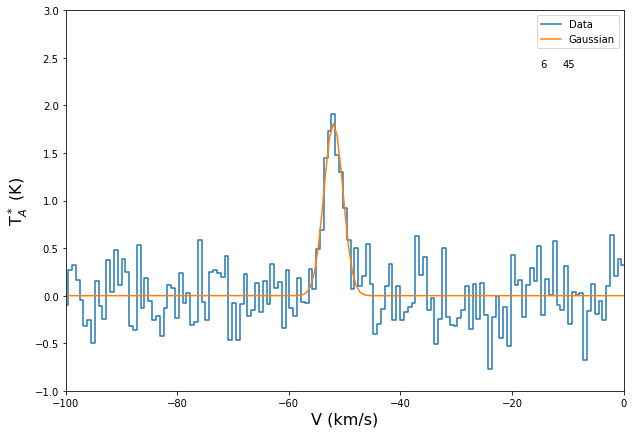

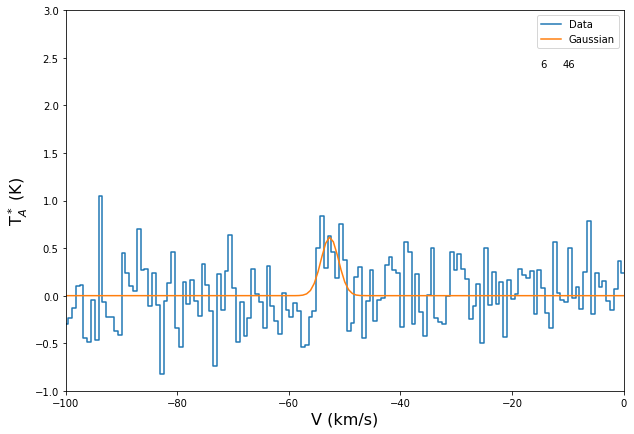

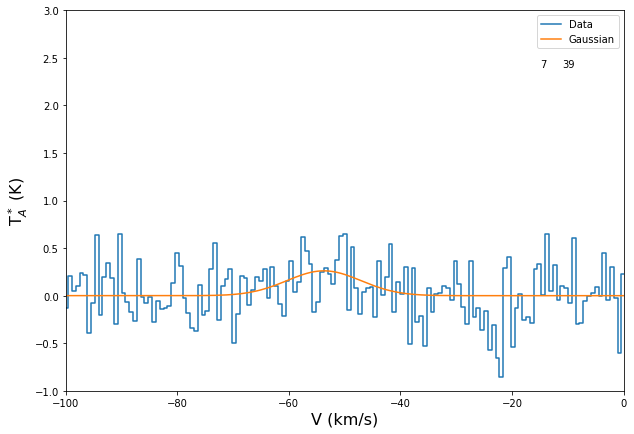

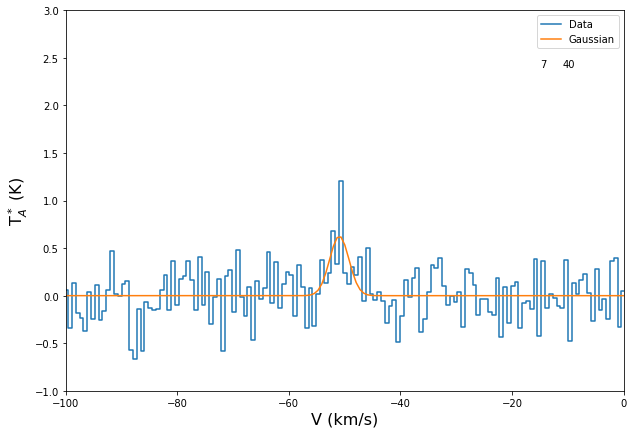

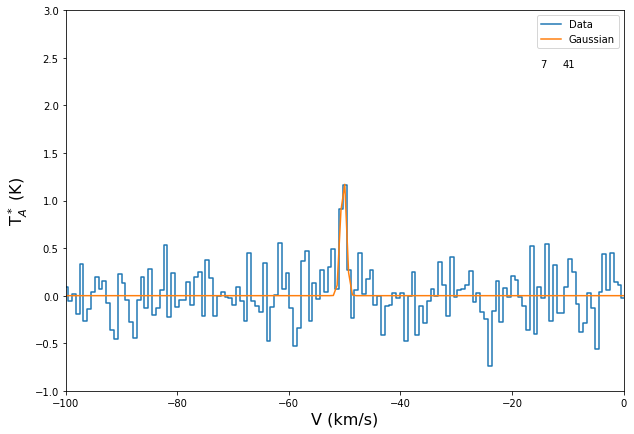

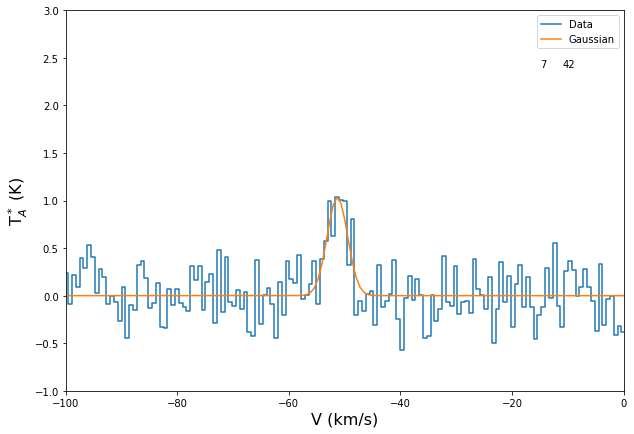

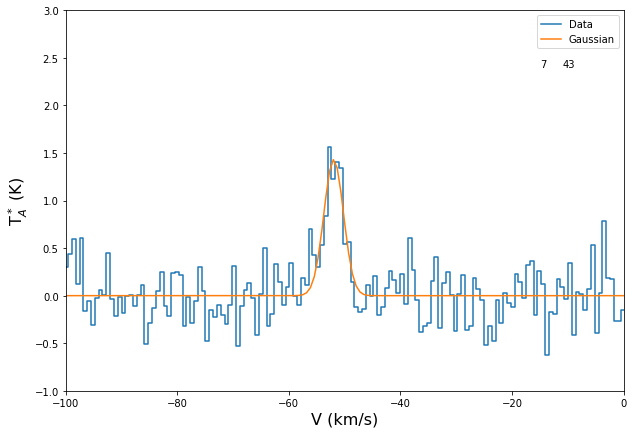

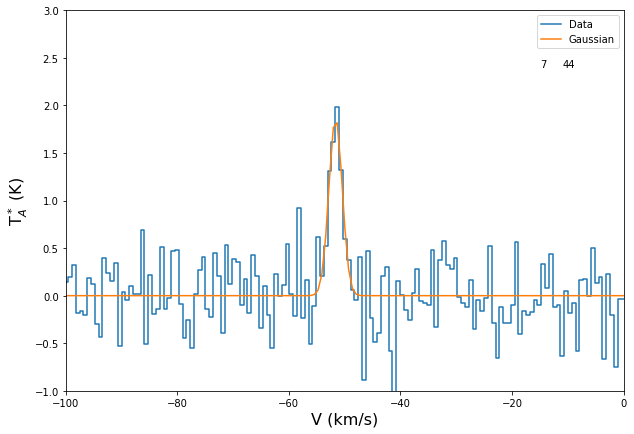

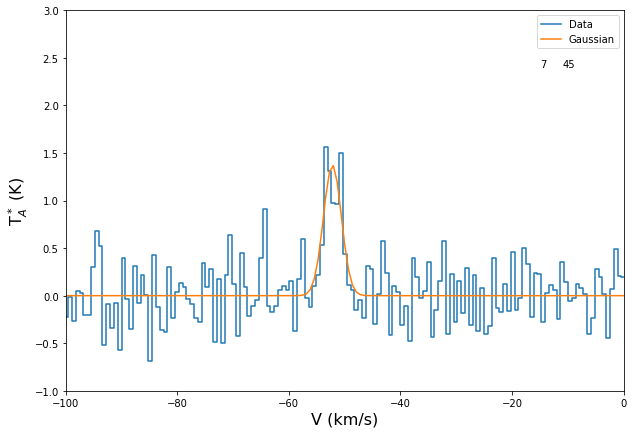

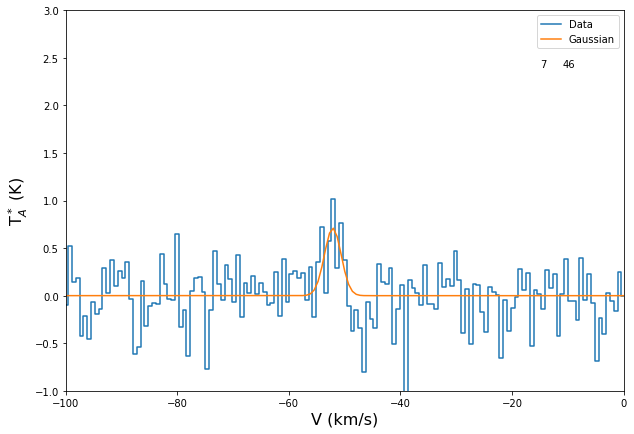

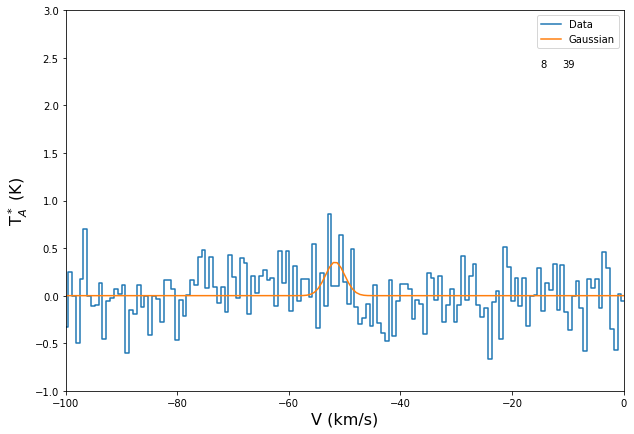

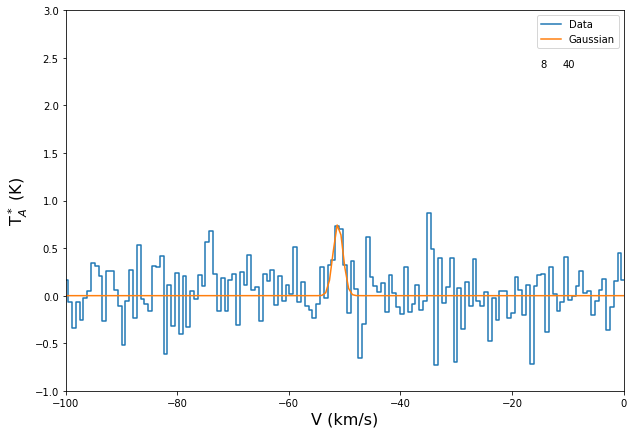

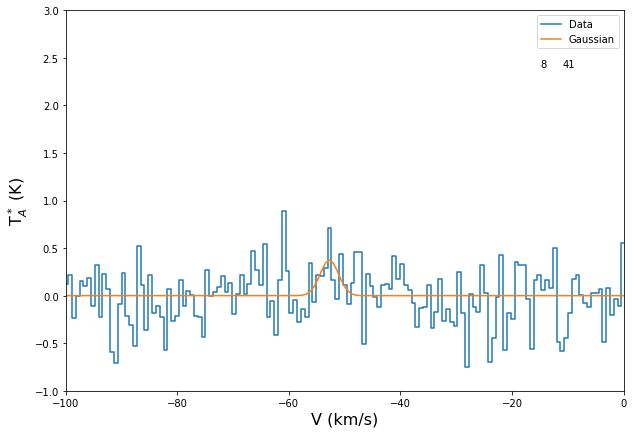

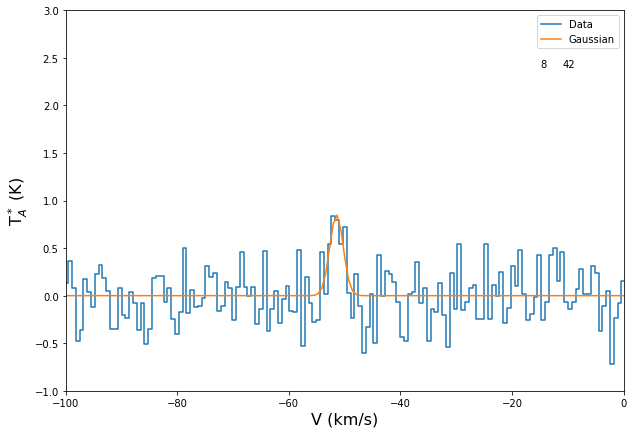

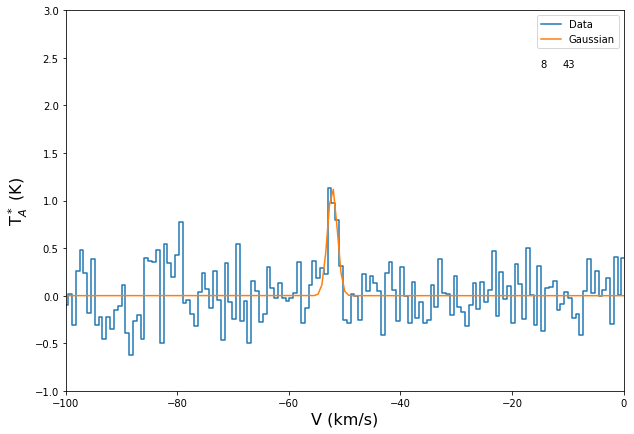

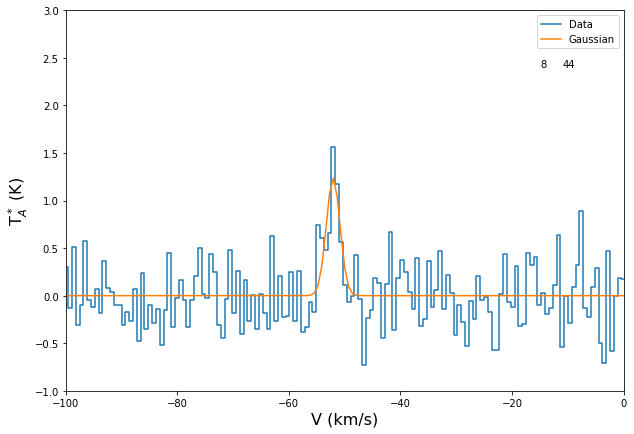

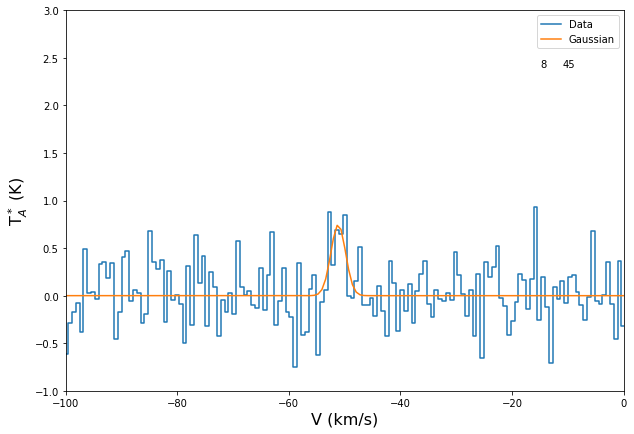

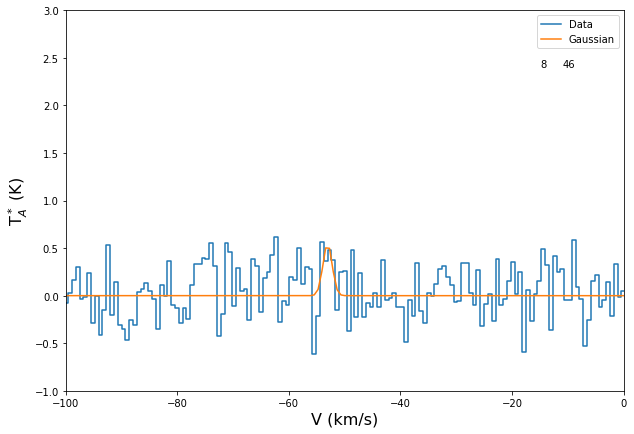

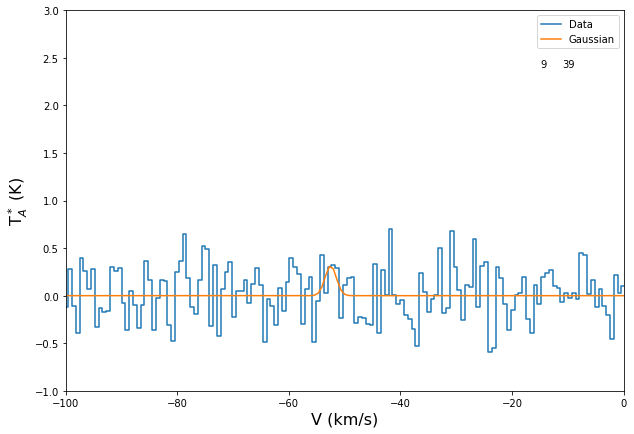

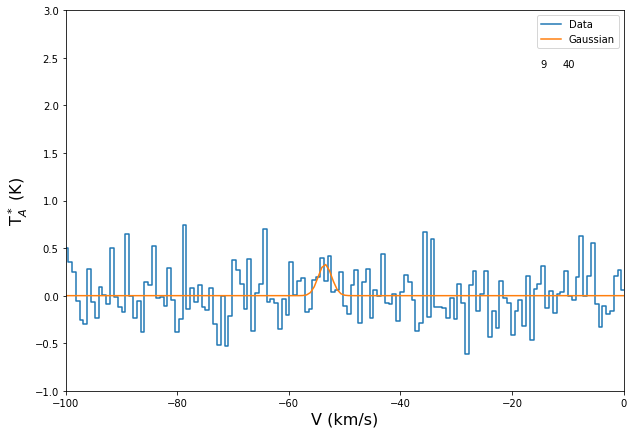

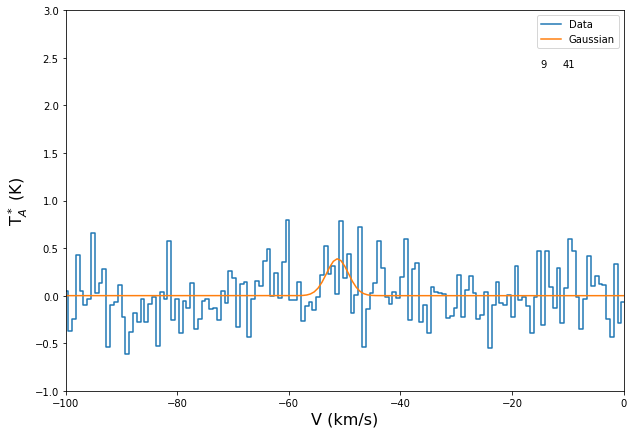

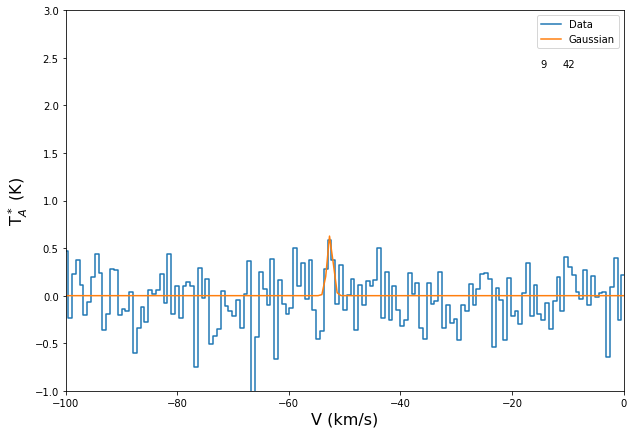

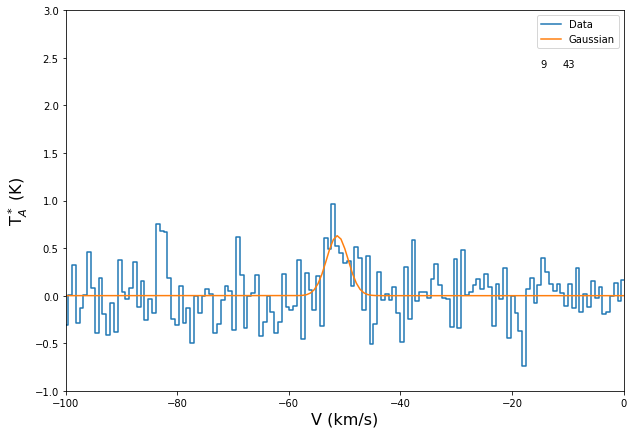

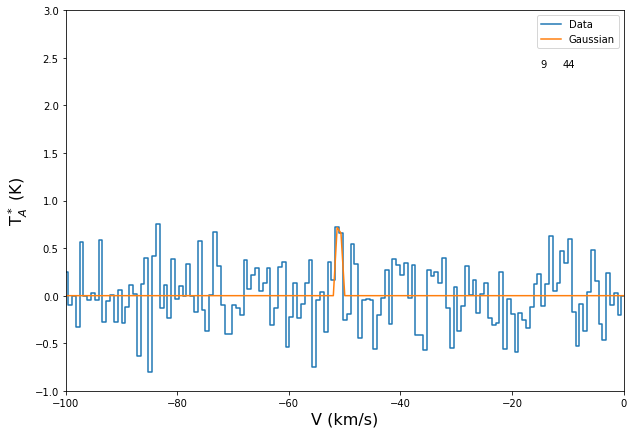

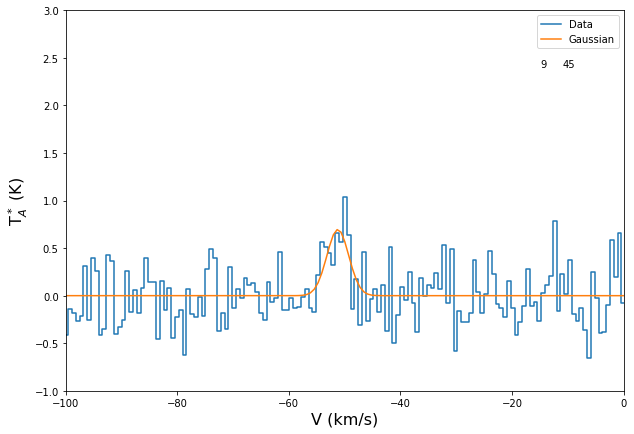

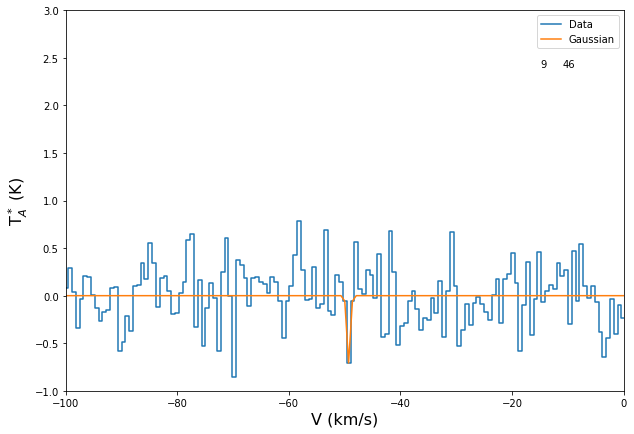

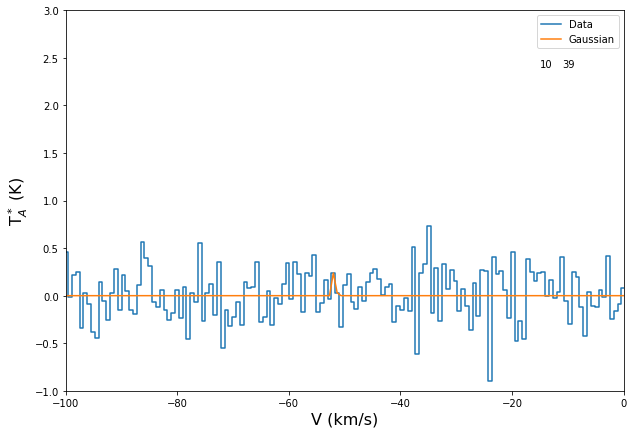

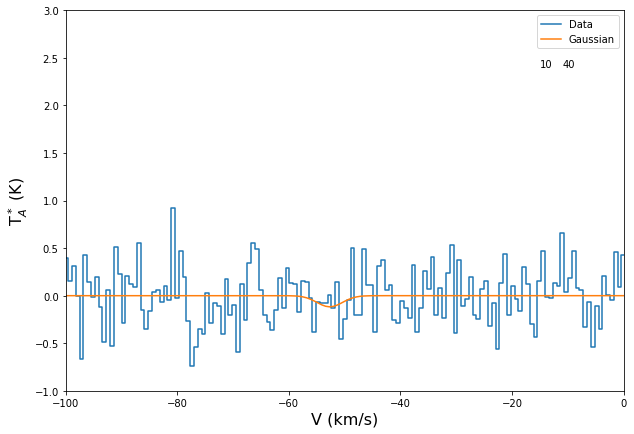

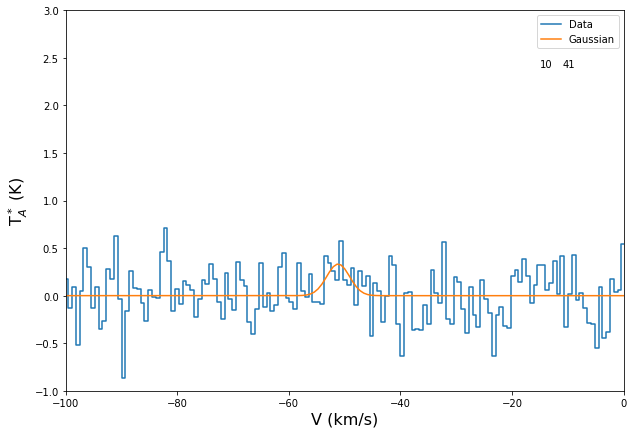

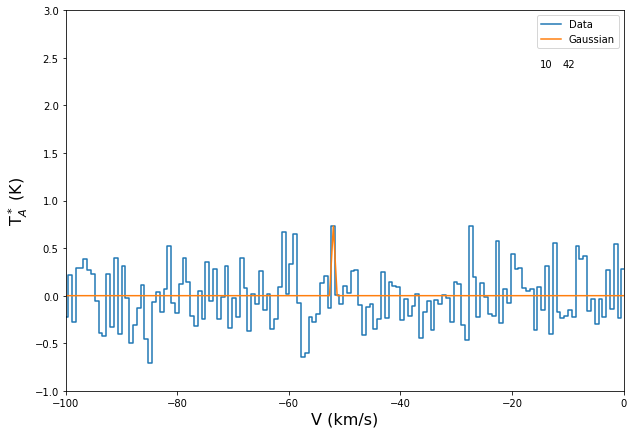

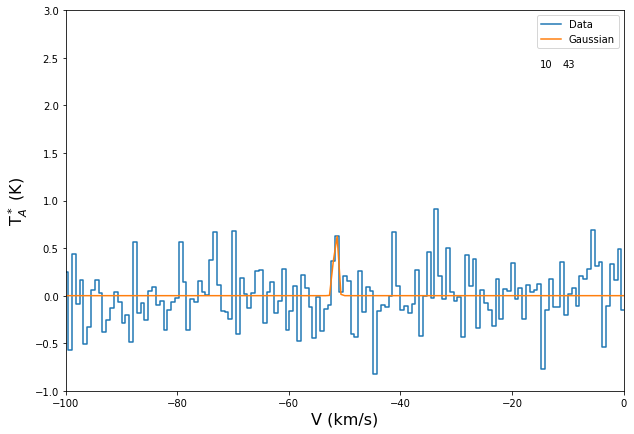

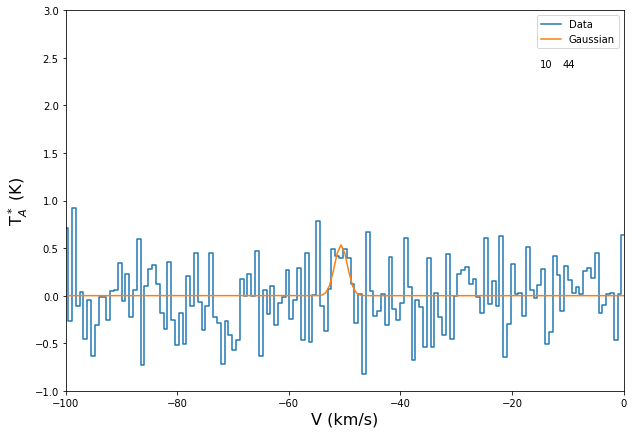

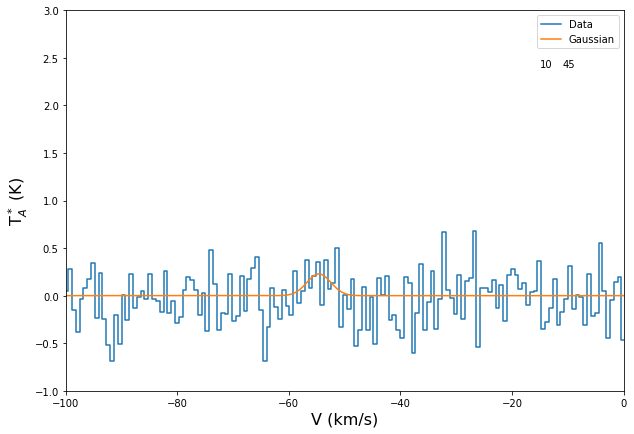

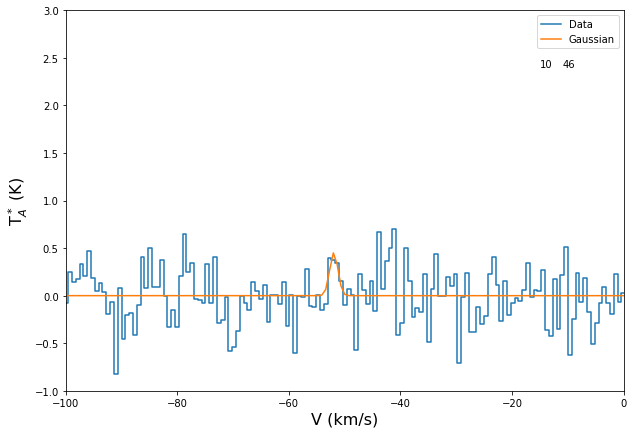

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import ascii
from astropy.table import Table

import warnings
warnings.filterwarnings('ignore') # Turn warnings off (because they're annoyong!)

# Change the parameters below for each new source
################################################

path='/Users/jane/Desktop'   # path to file
filename='s138_HCO+_smo.fits'       # input fits file name
outfile = 's138_HCO+_gaussfits.txt' # file name of the gaussian fit results

vel_guess = -52  # The initial guess for the centroid velocity of the gaussian fit
dv_min = 1       # set a minimum acceptable line width
dv_max = 9       # set a maximum acceptable line width
snr_min = 2.5    # set a minumum acceptable SNR

# set the range of pixels in the x direction over which to loop
min_xpix = 3
max_xpix = 10

# set the range of pixels in the y direction over which to loop
min_ypix = 39
max_ypix = 46

# set the velocity range over which to calculate the line integrated intensity
min_vline = -56
max_vline = -48

#set the spectral resolution of the spectra in km/s
deltaV = 0.4

#################################################

#JCMT efficiency at 230 GHz to convert TA* to Tmb
eta = 0.6

# retrieving the source data and information
datfile = fits.open(path+'/'+filename)
cube = SpectralCube.read(datfile)
wcs = WCS(datfile[0].header) # vel and position info from WCS in header

# extract the world coordinates of all the pixels using the world property, 
# which returns the spectral axis then the two positional coordinates in reverse order 
# (in the same order as the data indices). 
velo, lat, long  = cube.world[:] 

# convert the velocity units from m/s (in the fits header) to km/s
cube2 = cube.with_spectral_unit(u.km / u.s)

# print column headers to screen
print("x  y          Glat.                 Glong.           TA   Tmb    V     Sig   Fwhm")
print("                                                      K    K    km/s   km/s  km/s")
        
# initialize the arrays to write to an ascii table file at the end
x = []
y = []
glat = []
glong = []
vlsr = []
TA = []
sigma = []
fwhm = []
TAdv = []
Tmb = []
Tmbdv = []
figs = [] # to store gaussian plots in 

# sets an index for the array entries
n = 0

# Loop over all pixels in the x and y ranges provided, extract the spectrum at that pixel,
# fit a gaussian to the spectrum and print and plot the results
for i in range(min_xpix,max_xpix+1):
    for j in range(min_ypix,max_ypix+1):
        # grab a spectrum at pixel x, y 
        x.append(i)
        y.append(j)
        T = cube2[:, j, i]               # get the intensity/temperature along the spectral axis
        vel = cube2.spectral_axis        # set the velocity axis
        glat.append(lat[0,j,0])          # get the DEC/lat of pixel x/y from the world coordinates
        glong.append(long[0,0,i])        # get the RA/long of pixel x/y from the world coordinates

        # Fit the data using a Gaussian
        g_init = models.Gaussian1D(amplitude=1.0, mean=vel_guess, stddev=1.0)
        fit_g = fitting.LevMarLSQFitter()
        g = fit_g(g_init, vel, T)
        #print(g)
        
        gT = g.amplitude.value   # Line peak temperature of the gaussian fit  (K)
        gV = g.mean.value        # line centre velocity of the gaussian fit (km/s)
        gS = g.stddev.value      # standard deviation (sigma) width of the gaussian fit (km/s)
        
        noise = T.std()                      # Calculate the rms noise in the spectrum
        intnoise = deltaV * noise * u.km / u.s  # multiple the noise by the channel width we can calculate the SNR using the intergrated intensity/moment 0
        newgT = gT * u.K                     # give the Gaussian fit temp the units of K                   
        #print('noise = ',noise)
        #print('integrated noise = ', intnoise)
        #print('max = ',max)
              
        # calculate the integrated intensity of the spectrum over the line
        line = cube2.spectral_slab(min_vline*u.km / u.s, max_vline*u.km / u.s)
        max = line[:,j,i].max()       # calculate the maximum channel height in the region covered by the line
        mom0 = line.moment(order=0)
        mom_line = abs(mom0[j,i])     # extract the moment 0 value fo the desire x, y position/pixel
        #print('moment line =',mom_line)
  
        # calculate the SNR 
        snr = mom_line/intnoise
        #print('SNR = ',snr)
        
        # If the SNR is > some value, the max channel is >  something * noise
        # and the FWHM is > some minimum width and < some maximum width
        # then accept the values of the gaussian fits
        # if not, then we assume that the spectrum is weak, the fit is nonsense and so
        # we set the values to 0 so we know what to ignore in the table
        if snr > snr_min and max > (snr_min*noise) and (2.355*gS) > dv_min and (2.355*gS) < dv_max :
            TA.append(gT)               # Line peak temperature of the gaussian fit  (K)
            vlsr.append(gV)             # line centre velocity of the gaussian fit (km/s)
            sigma.append(gS)            # standard deviation (sigma) width of the gaussian fit (km/s)
            fwhm.append(2.355 * gS)     # Full Width at Half Maximum of the gaussian fit  (km/s)
            Tmb.append(gT/eta)          # Calibrated Line peak temperature of the gaussian fit  (K)
        else:
            TA.append(0)           # Line peak temperature of the gaussian fit  (K)
            vlsr.append(0)         # line centre velocity of the gaussian fit (km/s)
            sigma.append(0)        # standard deviation (sigma) width of the gaussian fit (km/s)
            fwhm.append(0)         # Full Width at Half Maximum of the gaussian fit  (km/s)
            Tmb.append(0)          # Calibrated Line peak temperature of the gaussian fit  (K)
        
        # print the fit results to the screen
        #print(x[n], y[n], glat[n], glong[n], "%5.2f"%TA[n], "%5.2f"%Tmb[n], "%5.2f"%vlsr[n],"%5.2f"%sigma[n], "%5.2f"%fwhm[n])
         
        # plot each of the spectra and fits    
        fig = plt.figure(figsize=(10,7), facecolor='white')
        ax = fig.add_subplot(111)  # make a single panel subplot
       # im = ax.plot(vel,T, label='Data')  # plot the data
        im = ax.step(vel, T, where='mid', label='Data')
        im = ax.plot(vel, g(vel), label='Gaussian') # plot the gaussian fit
        ax.set_xlim([-100,0])
        ax.set_ylim([-1,3])
        ax.set_xlabel("V (km/s)", fontsize=16)
        ax.set_ylabel("T$_A^*$ (K)", fontsize=16)
        ax.text(-15,2.4,i)
        ax.text(-11,2.4,j)
        ax.legend()
        figs.append(fig)
        
        n += 1    #increment the array index

# Set the header line, the parameters, and the format of the parameters to 
# write to an ascii table file        
out = Table()
out['Pix_x'] = x
out['Pix_y'] = y
out['GLat(deg)'] = glat
out['GLat(deg)'].info.format = '8.5f'
out['GLong(deg)'] = glong
out['GLong(deg)'].info.format = '8.5f'
out['TA(K)'] = TA
out['TA(K)'].info.format = '6.2f'
out['Tmb(K)'] = Tmb
out['Tmb(K)'].info.format = '6.2f'
out['VLSR(km/s)'] = vlsr
out['VLSR(km/s)'].info.format = '6.2f'
out['sigma(km/s)'] = sigma
out['sigma(km/s)'].info.format = '6.2f'
out['FWHM(km/s)'] = fwhm
out['FWHM(km/s)'].info.format = '6.2f'
#out['TAdv(K km/s)'] = TAdv
#out['TAdv(K km/s)'].info.format = '6.2f'
#out['Tmbdv(K km/s)'] = Tmbdv
#out['Tmbdv(K km/s)'].info.format = '6.2f'

# Write the gaussian fits of all pixels to a text file 
ascii.write(out, path+'/'+outfile,  overwrite=True, format='tab')

# Turn warnings back on
warnings.filterwarnings('default')

plt.savefig("/Users/jane/Desktop/plot.pdf",format='pdf')

from matplotlib.backends.backend_pdf import PdfPages

def save_multi_image(filename):
   pp = PdfPages(filename)
   for fig in figs:
      fig.savefig(pp, format='pdf')
   pp.close()

filename = "multi.pdf"
save_multi_image(filename)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def save_multi_image(filename):
   pp = PdfPages(filename)
   fig_nums = plt.get_fignums()
   figs = [plt.figure(n) for n in fig_nums]
   for fig in figs:
      fig.savefig(pp, format='pdf')
   pp.close()

filename = "multi.pdf"
save_multi_image(filename)